# Skill Test document

* Name: Vadim Sokoltsov
* Date: 06.10.2025
* E-mail: 

Note: Please make sure you send the necessary documentation to run this notebook. If you installed any library do not forget to send the requirements.txt

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Useful line of code to set the display option so we could see all the columns/rows in pd dataframe
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:
trx = pd.read_csv("./transactions.csv", parse_dates=['TX_DATETIME'], dtype = {'CUSTOMER_ID': np.int64,'SECTOR_ID': np.int64,'TX_FRAUD': np.int8})

# EDA

## Validating assumptions

Here we validate some first level assumptions on the data.

In [3]:
#Each customer has an unique sector
(trx.groupby('CUSTOMER_ID').SECTOR_ID.nunique() == 1).all()

np.True_

In [4]:
#No NANs in the data 
trx.isna().any()

CUSTOMER_ID    False
TX_DATETIME    False
TX_AMOUNT      False
SECTOR_ID      False
TX_FRAUD       False
dtype: bool

In [5]:
#Data types
trx.dtypes

CUSTOMER_ID             int64
TX_DATETIME    datetime64[ns]
TX_AMOUNT             float64
SECTOR_ID               int64
TX_FRAUD                 int8
dtype: object

## Descriptive Analysis

In [6]:
#Total transactions and columns
nb_transactions = len(trx)
nb_customers = trx.CUSTOMER_ID.nunique()
nb_sectors = trx.SECTOR_ID.nunique()
nb_frauds = len(trx[trx.TX_FRAUD == 1])
start_date = trx.TX_DATETIME.min()
end_date = trx.TX_DATETIME.max()
nb_days = (end_date - start_date).days

print(f"We have a total of {nb_transactions} transactions")
print(f"We have a total of {nb_frauds} frauds")
print(f"The dataset starts at {start_date} and ends at {end_date}. There are {nb_days} days in total")
print(f"They come from {nb_customers} customers from {nb_sectors} different sectors.")

We have a total of 1229921 transactions
We have a total of 3779 frauds
The dataset starts at 2023-01-01 00:21:42 and ends at 2023-06-18 13:37:52. There are 168 days in total
They come from 5000 customers from 20 different sectors.


In [7]:
trx.describe()

,CUSTOMER_ID,TX_DATETIME,TX_AMOUNT,SECTOR_ID,TX_FRAUD
count,1.229921e+06,1229921,1.229921e+06,1.229921e+06,1.229921e+06
mean,2.498093e+03,2023-03-28 05:59:47.830255616,5.283276e+02,9.541541e+00,3.072555e-03
min,0.000000e+00,2023-01-01 00:21:42,1.415089e+01,0.000000e+00,0.000000e+00
25%,1.247000e+03,2023-02-15 03:41:01,1.234908e+02,4.000000e+00,0.000000e+00
50%,2.497000e+03,2023-03-28 08:57:58,4.294975e+02,1.000000e+01,0.000000e+00
75%,3.744000e+03,2023-05-08 11:51:48,6.871575e+02,1.500000e+01,0.000000e+00
max,4.999000e+03,2023-06-18 13:37:52,4.328488e+03,1.900000e+01,1.000000e+00
std,1.442027e+03,NaN,5.218334e+02,5.825168e+00,5.534543e-02


In [8]:
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229921 entries, 0 to 1229920
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   CUSTOMER_ID  1229921 non-null  int64         
 1   TX_DATETIME  1229921 non-null  datetime64[ns]
 2   TX_AMOUNT    1229921 non-null  float64       
 3   SECTOR_ID    1229921 non-null  int64         
 4   TX_FRAUD     1229921 non-null  int8          
dtypes: datetime64[ns](1), float64(1), int64(2), int8(1)
memory usage: 38.7 MB


In [9]:
trx.head(5)

,CUSTOMER_ID,TX_DATETIME,TX_AMOUNT,SECTOR_ID,TX_FRAUD
0,2541,2023-01-01 00:21:42,499.210846,11,0
1,1735,2023-01-01 00:21:59,58.824293,3,0
2,669,2023-01-01 00:36:40,91.967189,12,0
3,4235,2023-01-01 00:51:34,836.571053,16,0
4,2162,2023-01-01 01:15:23,1537.707662,19,0


In [10]:
trx.columns = trx.columns.str.lower().str.replace(" ", "_")

In [11]:
trx.head(5)

,customer_id,tx_datetime,tx_amount,sector_id,tx_fraud
0,2541,2023-01-01 00:21:42,499.210846,11,0
1,1735,2023-01-01 00:21:59,58.824293,3,0
2,669,2023-01-01 00:36:40,91.967189,12,0
3,4235,2023-01-01 00:51:34,836.571053,16,0
4,2162,2023-01-01 01:15:23,1537.707662,19,0


<Axes: xlabel='tx_amount', ylabel='Count'>

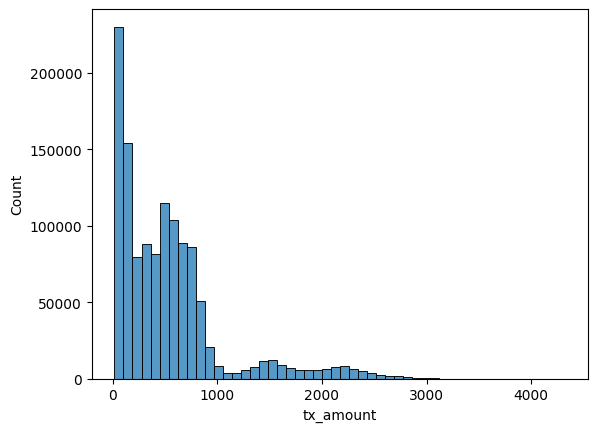

In [12]:
sns.histplot(trx['tx_amount'], bins=50)

Since `tx_amount` column has a long tail, it makes sense to represent it as `log()`value

<Axes: xlabel='tx_amount', ylabel='Count'>

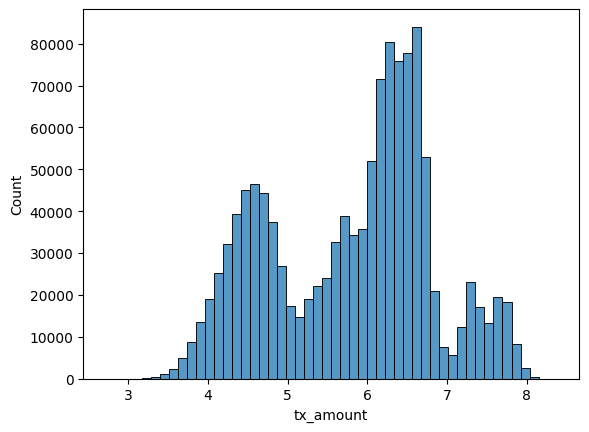

In [13]:
sns.histplot(np.log1p(trx['tx_amount']), bins=50)

In [14]:
trx['tx_amount_log'] = np.log1p(trx['tx_amount'])

## Data visualization

### Distribution of fraud / non-fraud transactions

In [15]:
trx['tx_fraud'].value_counts(normalize=True)

tx_fraud
0    0.996927
1    0.003073
Name: proportion, dtype: float64

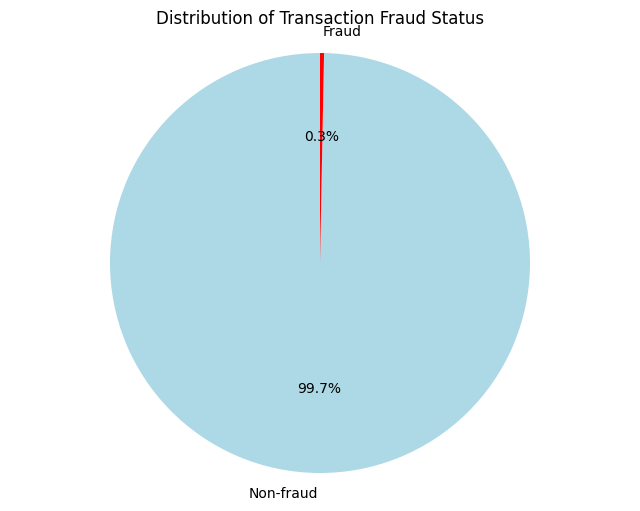

In [16]:
plt.figure(figsize=(8,6))
fraud_counts = trx['tx_fraud'].value_counts()
labels = ['Non-fraud', 'Fraud'] if 0 in fraud_counts else ['Fraud']

plt.pie(fraud_counts.values, 
        labels=labels, 
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightblue', 'red'])

plt.title('Distribution of Transaction Fraud Status')
plt.axis('equal') 
plt.show()

#### Observations

* Dataset is highly imbalanced (`0.3%` of fraud transactions)

### Total spending by sector

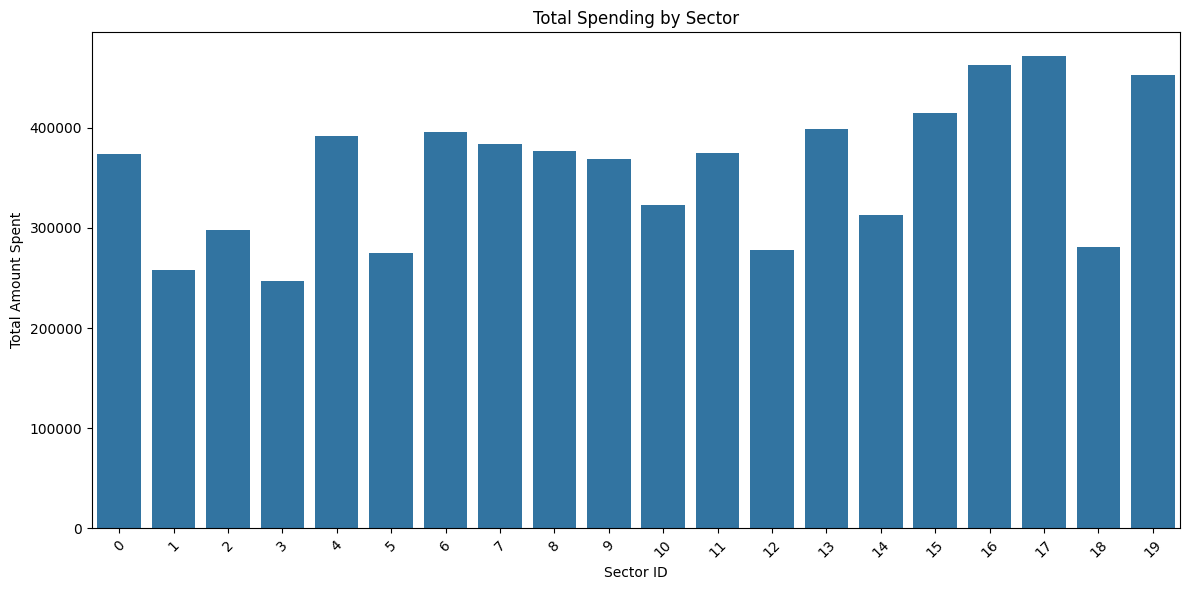

In [17]:
sector_spending = trx.groupby('sector_id')['tx_amount_log'].sum().reset_index()

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=sector_spending, x='sector_id', y='tx_amount_log')
plt.title('Total Spending by Sector')
plt.xlabel('Sector ID')
plt.ylabel('Total Amount Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distributions by sector

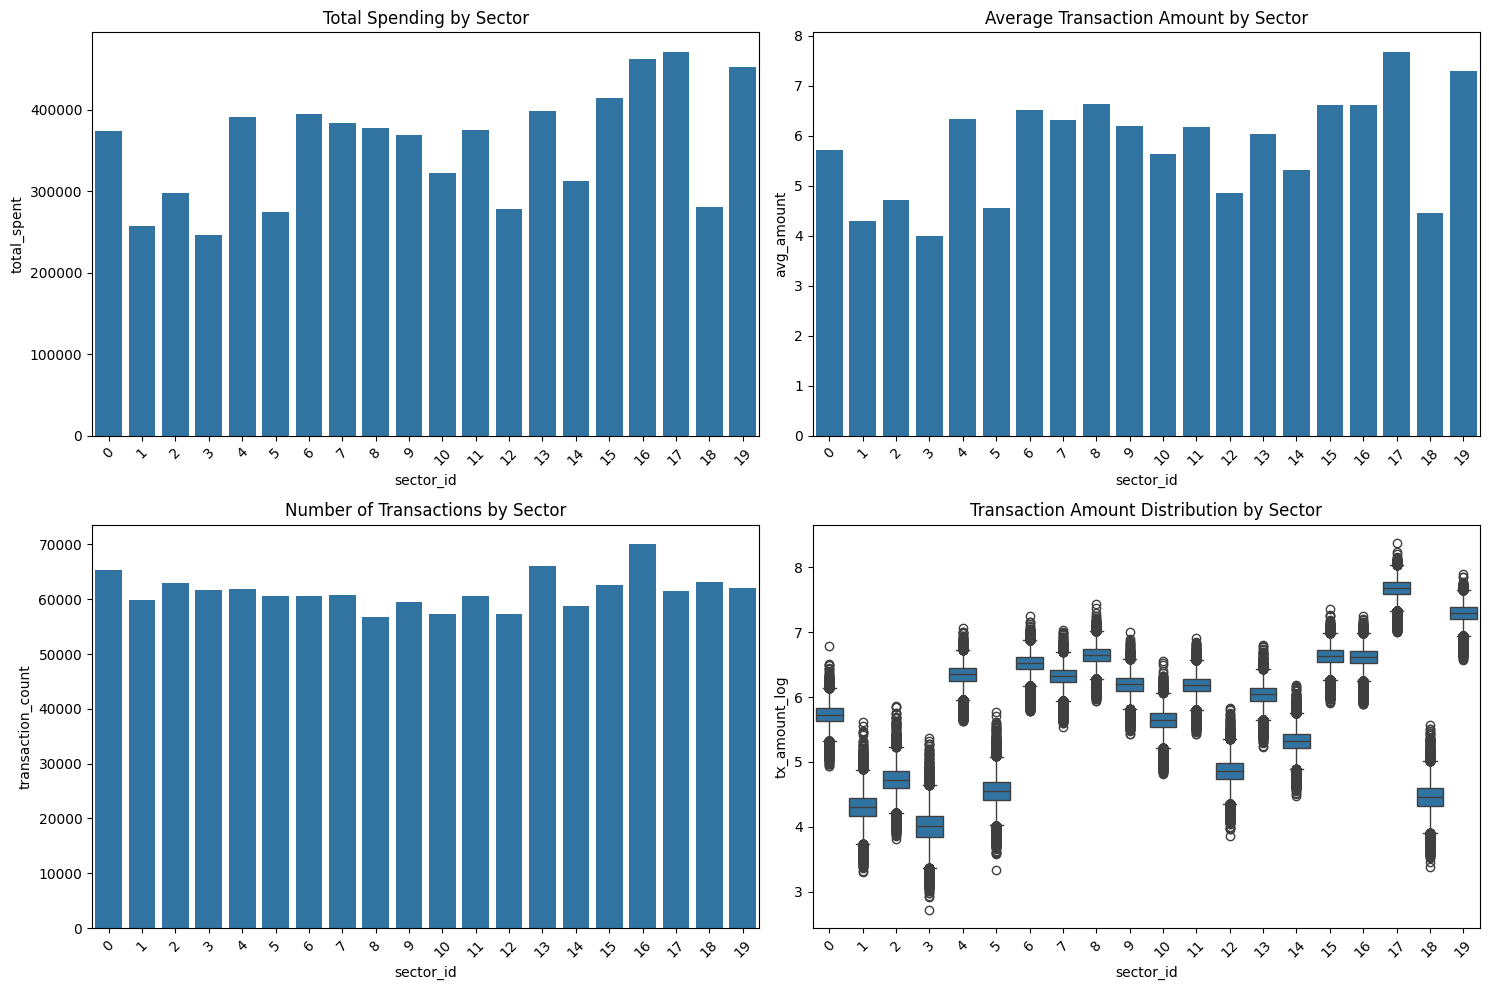

In [18]:
sector_summary = trx.groupby('sector_id').agg({
    'tx_amount_log': ['sum', 'mean', 'count']
}).round(2)
sector_summary.columns = ['total_spent', 'avg_amount', 'transaction_count']
sector_summary = sector_summary.reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.barplot(data=sector_summary, x='sector_id', y='total_spent', ax=axes[0,0])
axes[0,0].set_title('Total Spending by Sector')
axes[0,0].tick_params(axis='x', rotation=45)

sns.barplot(data=sector_summary, x='sector_id', y='avg_amount', ax=axes[0,1])
axes[0,1].set_title('Average Transaction Amount by Sector')
axes[0,1].tick_params(axis='x', rotation=45)

sns.barplot(data=sector_summary, x='sector_id', y='transaction_count', ax=axes[1,0])
axes[1,0].set_title('Number of Transactions by Sector')
axes[1,0].tick_params(axis='x', rotation=45)

sns.boxplot(data=trx, x='sector_id', y='tx_amount_log', ax=axes[1,1])
axes[1,1].set_title('Transaction Amount Distribution by Sector')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Fraud transactions by sector

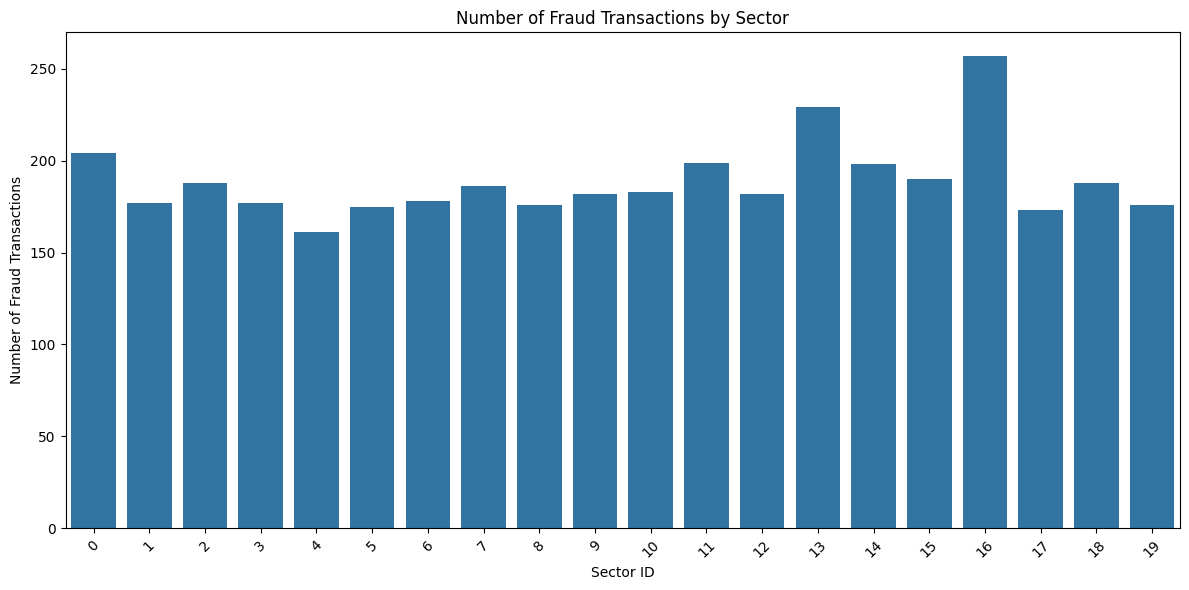

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_by_sector = trx.groupby('sector_id')['tx_fraud'].sum().reset_index()
fraud_by_sector.columns = ['sector_id', 'fraud_count']

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_sector, x='sector_id', y='fraud_count')
plt.title('Number of Fraud Transactions by Sector')
plt.xlabel('Sector ID')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of fraud / non-fraud transactions by sector

<Figure size 1200x600 with 0 Axes>

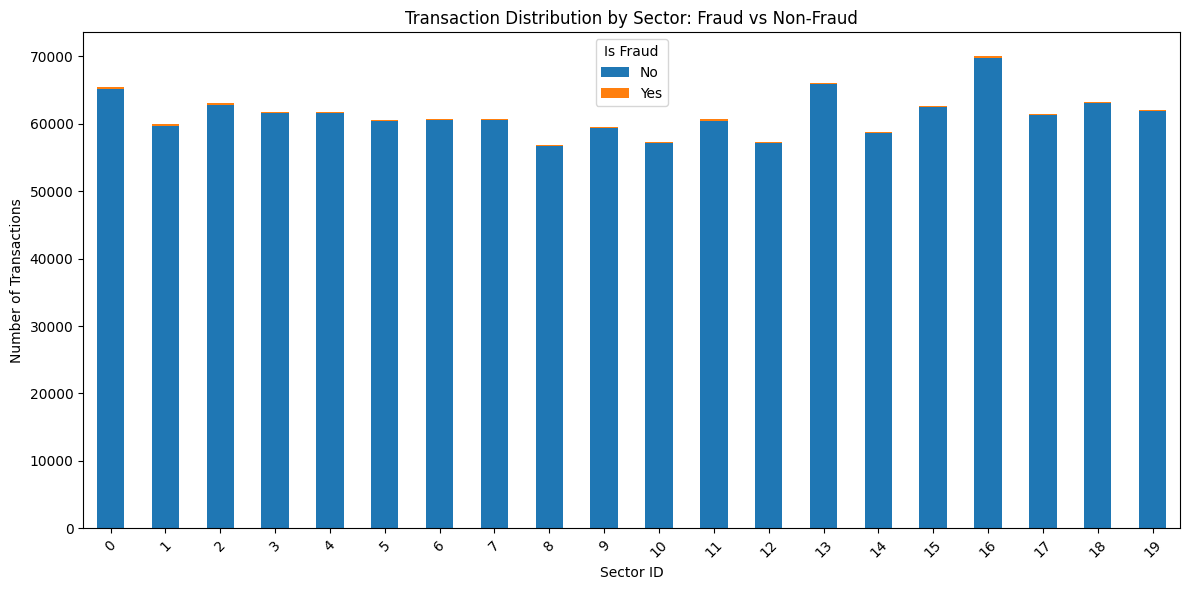

In [20]:
fraud_pivot = trx.groupby(['sector_id', 'tx_fraud']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
fraud_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transaction Distribution by Sector: Fraud vs Non-Fraud')
plt.xlabel('Sector ID')
plt.ylabel('Number of Transactions')
plt.legend(title='Is Fraud', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fraud transaction relations

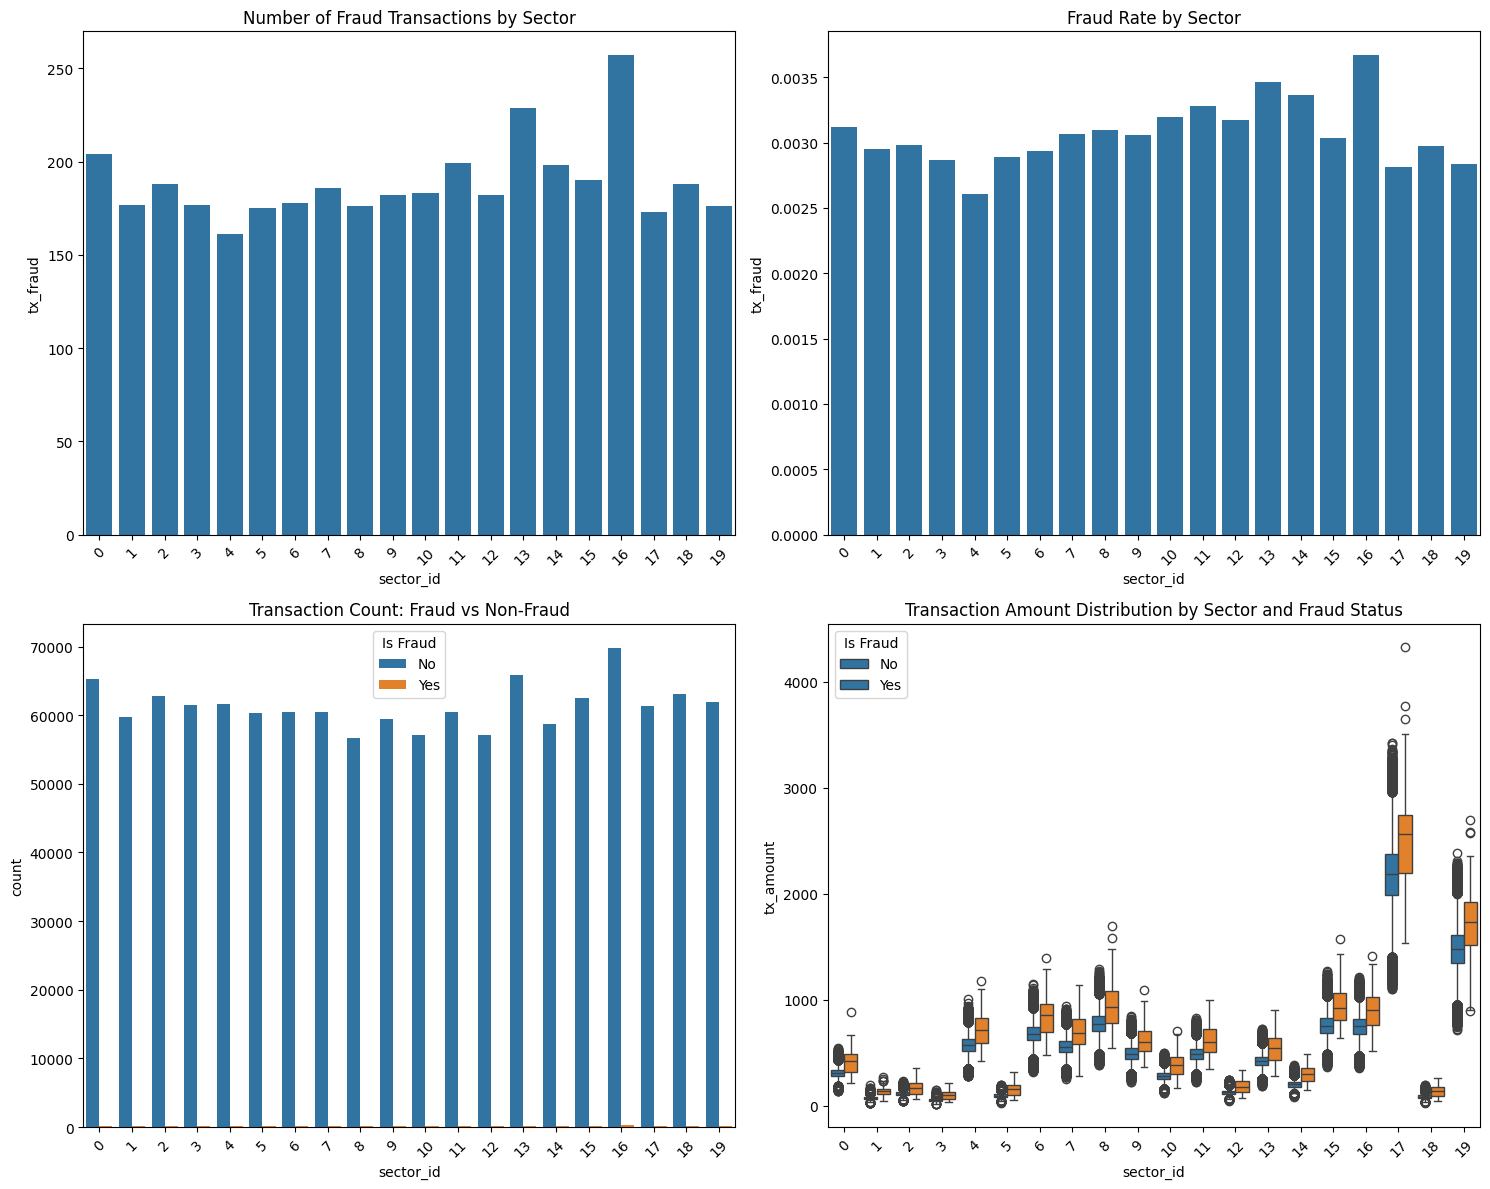

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

fraud_count = trx.groupby('sector_id')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_count, x='sector_id', y='tx_fraud', ax=axes[0,0])
axes[0,0].set_title('Number of Fraud Transactions by Sector')
axes[0,0].tick_params(axis='x', rotation=45)

fraud_rate = trx.groupby('sector_id')['tx_fraud'].mean().reset_index()
sns.barplot(data=fraud_rate, x='sector_id', y='tx_fraud', ax=axes[0,1])
axes[0,1].set_title('Fraud Rate by Sector')
axes[0,1].tick_params(axis='x', rotation=45)

sns.countplot(data=trx, x='sector_id', hue='tx_fraud', ax=axes[1,0])
axes[1,0].set_title('Transaction Count: Fraud vs Non-Fraud')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Is Fraud', labels=['No', 'Yes'])

sns.boxplot(data=trx, x='sector_id', y='tx_amount', hue='tx_fraud', ax=axes[1,1])
axes[1,1].set_title('Transaction Amount Distribution by Sector and Fraud Status')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(title='Is Fraud', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

### Number of frauds by hour

First, add features based on `tx_datetime`:

In [22]:
trx['day_of_week'] = trx['tx_datetime'].dt.day_of_week
trx['hour'] = trx['tx_datetime'].dt.hour
trx['month'] = trx['tx_datetime'].dt.month
trx['is_month_start'] = trx['tx_datetime'].dt.is_month_start.astype('int')
trx['is_month_end'] = trx['tx_datetime'].dt.is_month_end.astype('int')
trx['is_weekend'] = trx['day_of_week'].isin({5, 6}).astype('int')

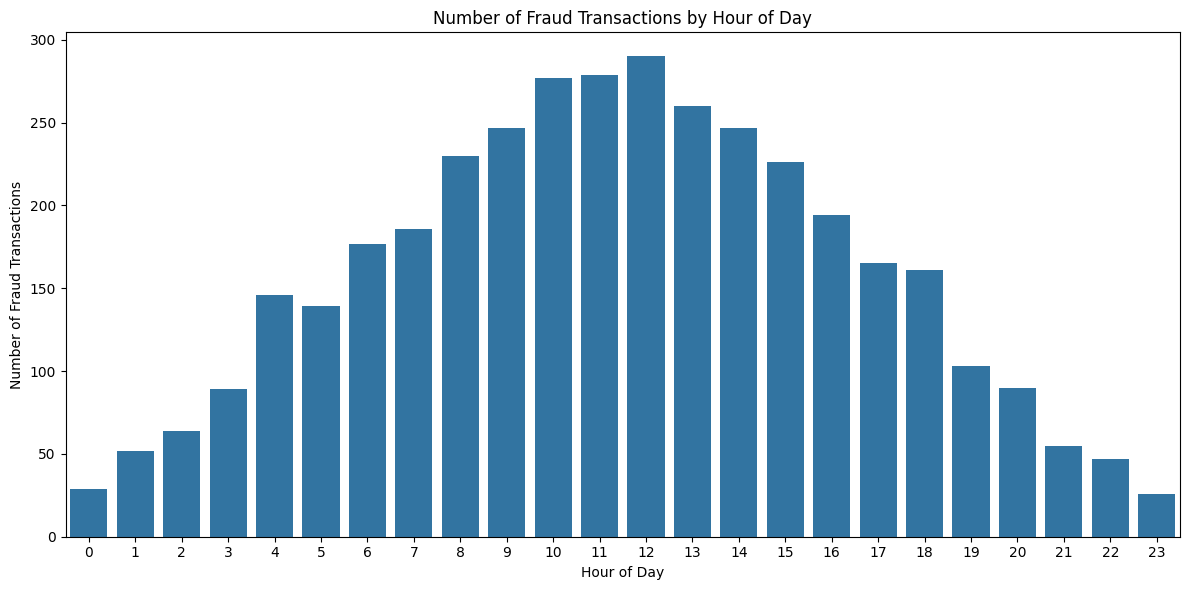

In [23]:
fraud_by_hour = trx.groupby('hour')['tx_fraud'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_hour, x='hour', y='tx_fraud')
plt.title('Number of Fraud Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraud Transactions')
plt.tight_layout()
plt.show()

### Fraud rate by hour of day

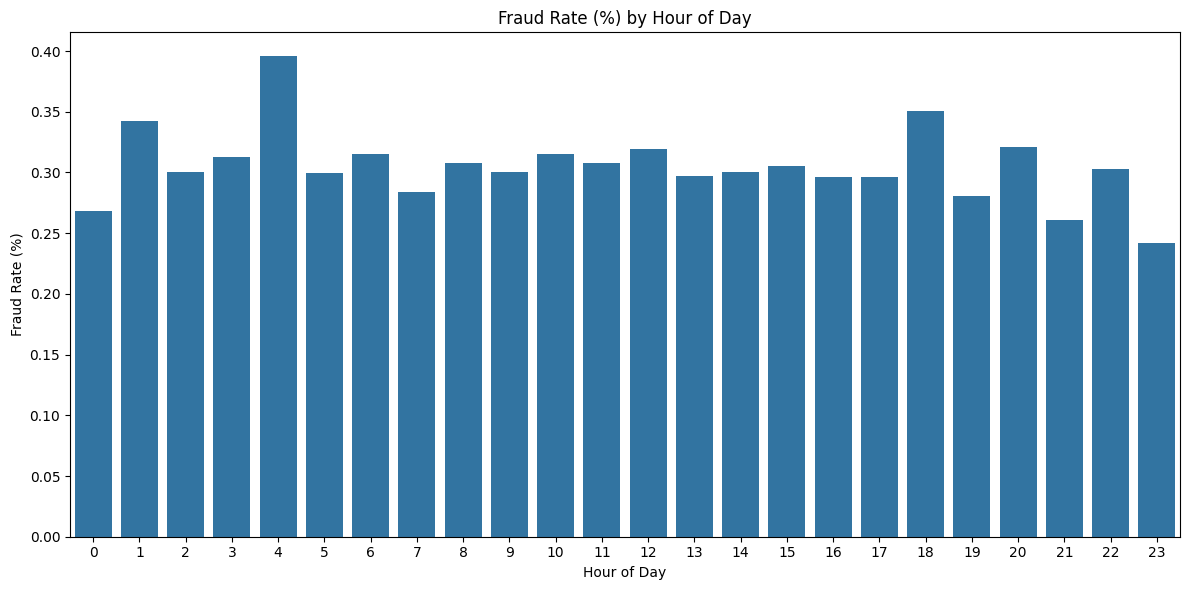

In [24]:
fraud_rate_hour = trx.groupby('hour')['tx_fraud'].agg(['sum', 'count']).reset_index()
fraud_rate_hour['fraud_rate'] = (fraud_rate_hour['sum'] / fraud_rate_hour['count']) * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_rate_hour, x='hour', y='fraud_rate')
plt.title('Fraud Rate (%) by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

### Frauds by day of the week

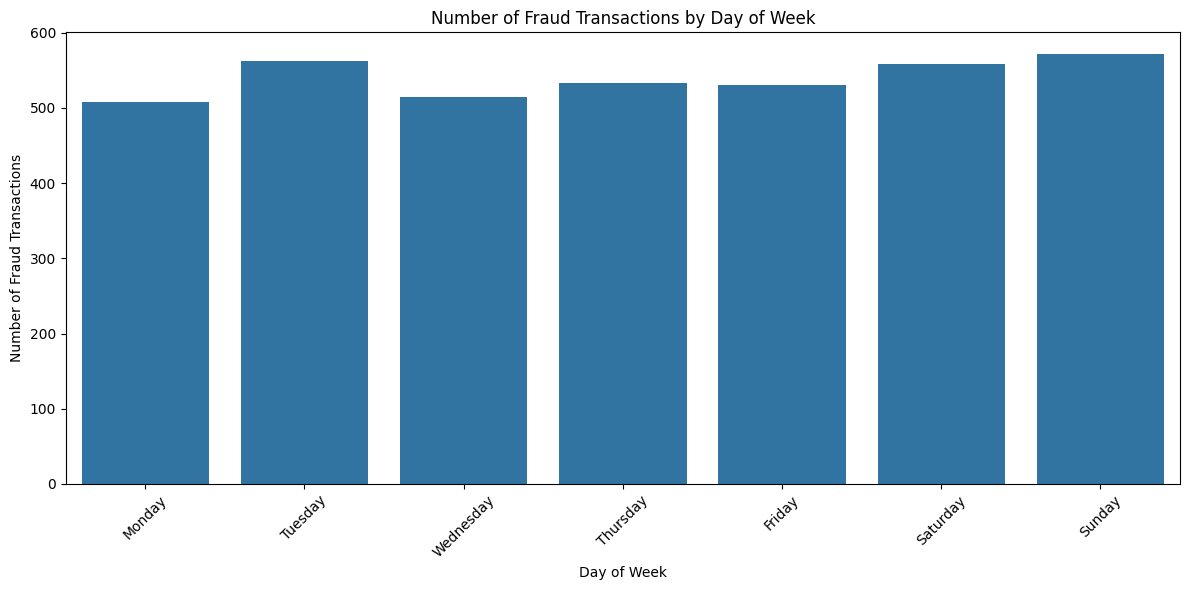

In [25]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fraud_by_day = trx.groupby('day_of_week')['tx_fraud'].sum().reset_index()
fraud_by_day['day_name'] = fraud_by_day['day_of_week'].map(lambda x: day_names[x])

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_day, x='day_name', y='tx_fraud')
plt.title('Number of Fraud Transactions by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fraud transactions by month

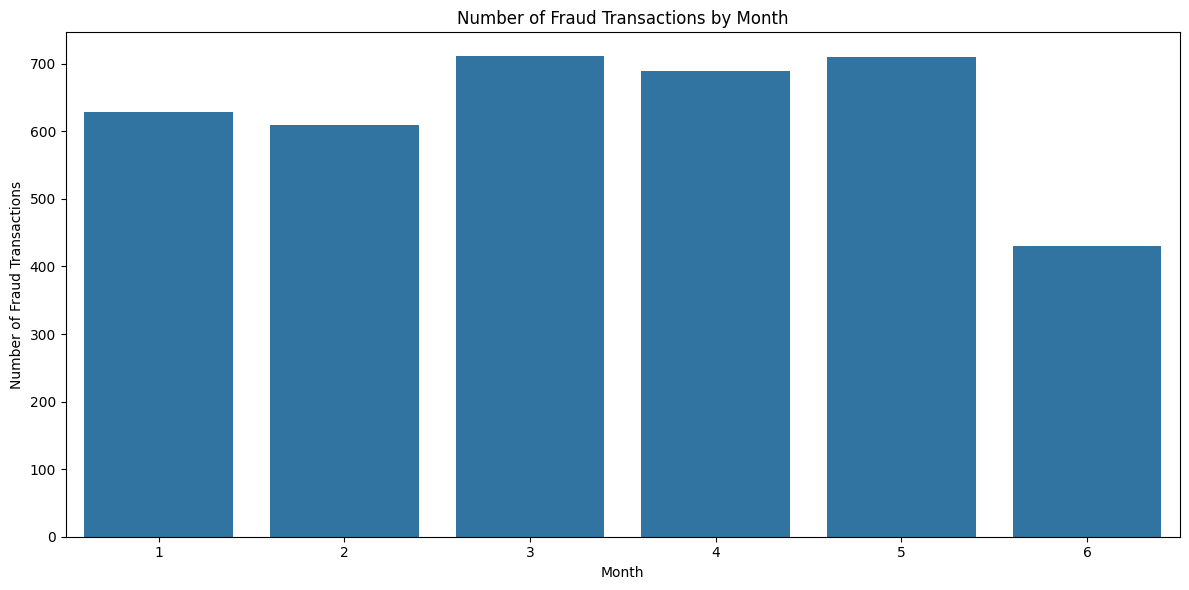

In [26]:
fraud_by_month = trx.groupby('month')['tx_fraud'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_month, x='month', y='tx_fraud')
plt.title('Number of Fraud Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fraud Transactions')
plt.tight_layout()
plt.show()

### Fraud by date attributes

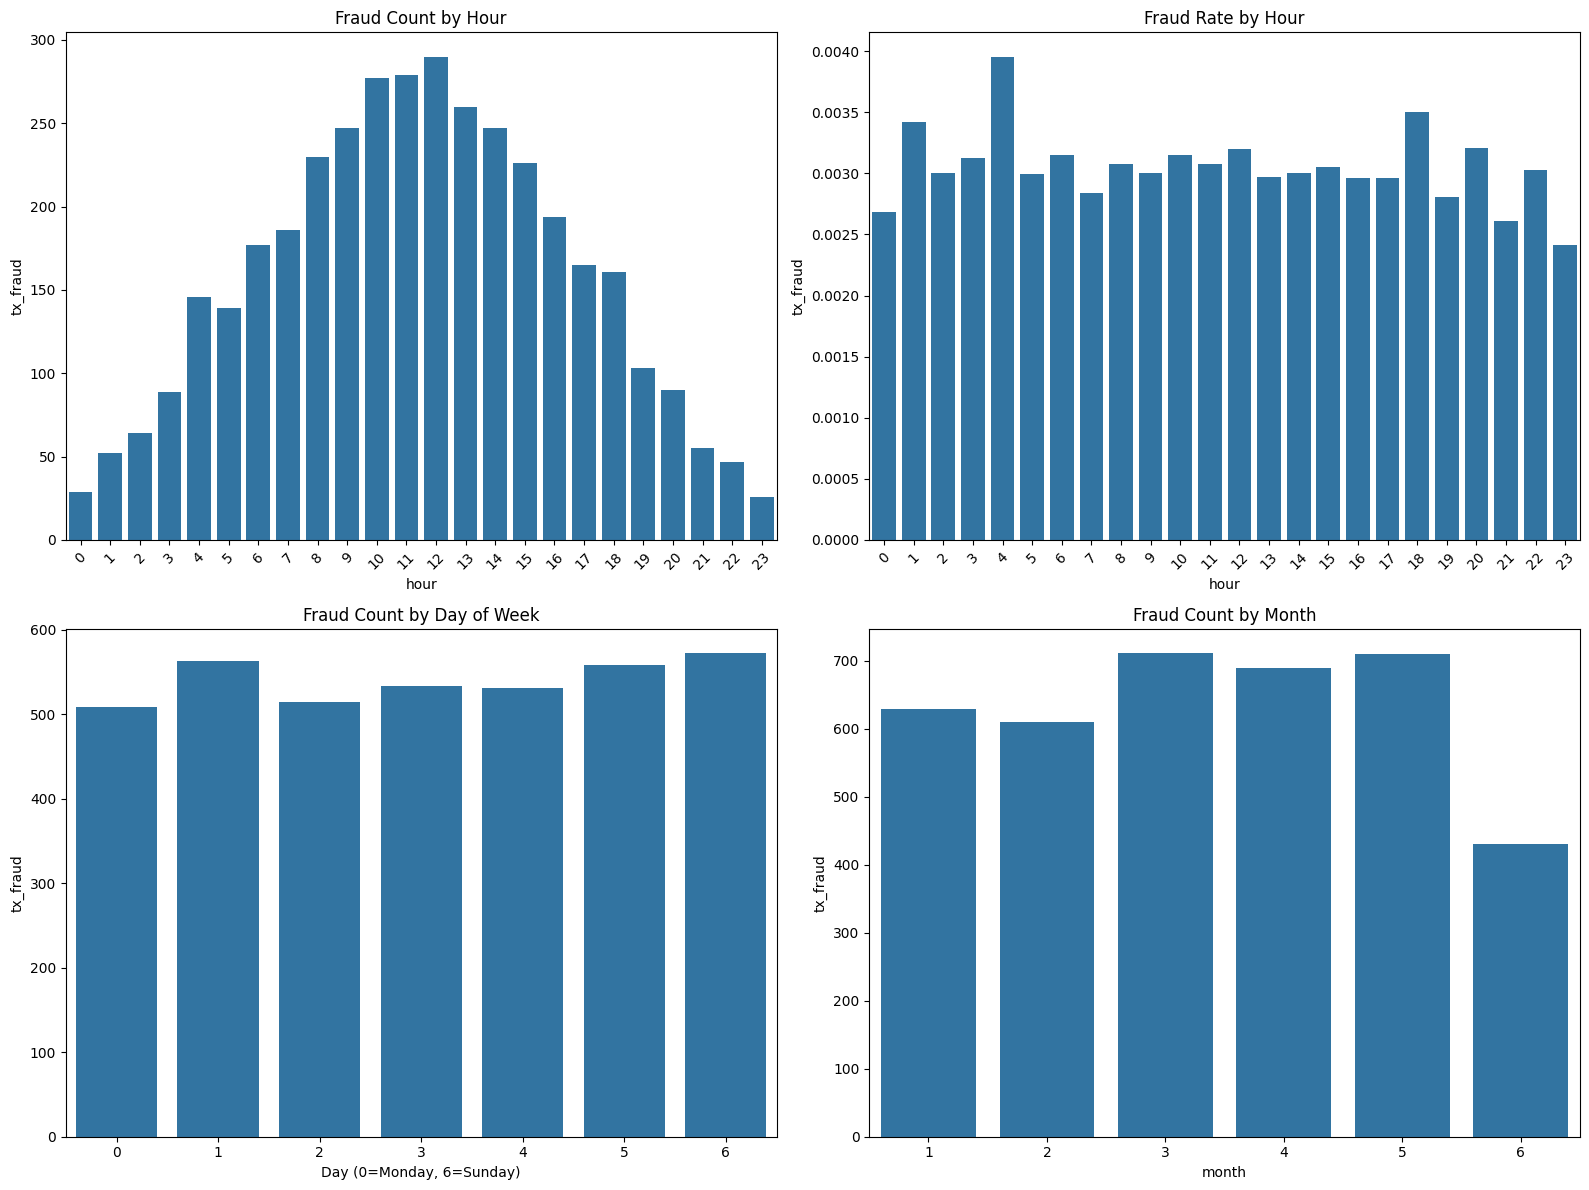

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

fraud_hour = trx.groupby('hour')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_hour, x='hour', y='tx_fraud', ax=axes[0,0])
axes[0,0].set_title('Fraud Count by Hour')
axes[0,0].tick_params(axis='x', rotation=45)

fraud_rate_hour = trx.groupby('hour')['tx_fraud'].mean().reset_index()
sns.barplot(data=fraud_rate_hour, x='hour', y='tx_fraud', ax=axes[0,1])
axes[0,1].set_title('Fraud Rate by Hour')
axes[0,1].tick_params(axis='x', rotation=45)

fraud_day = trx.groupby('day_of_week')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_day, x='day_of_week', y='tx_fraud', ax=axes[1,0])
axes[1,0].set_title('Fraud Count by Day of Week')
axes[1,0].set_xlabel('Day (0=Monday, 6=Sunday)')

fraud_month = trx.groupby('month')['tx_fraud'].sum().reset_index()
sns.barplot(data=fraud_month, x='month', y='tx_fraud', ax=axes[1,1])
axes[1,1].set_title('Fraud Count by Month')

plt.tight_layout()
plt.show()

### Fraud heatmap: Day of week vs hour

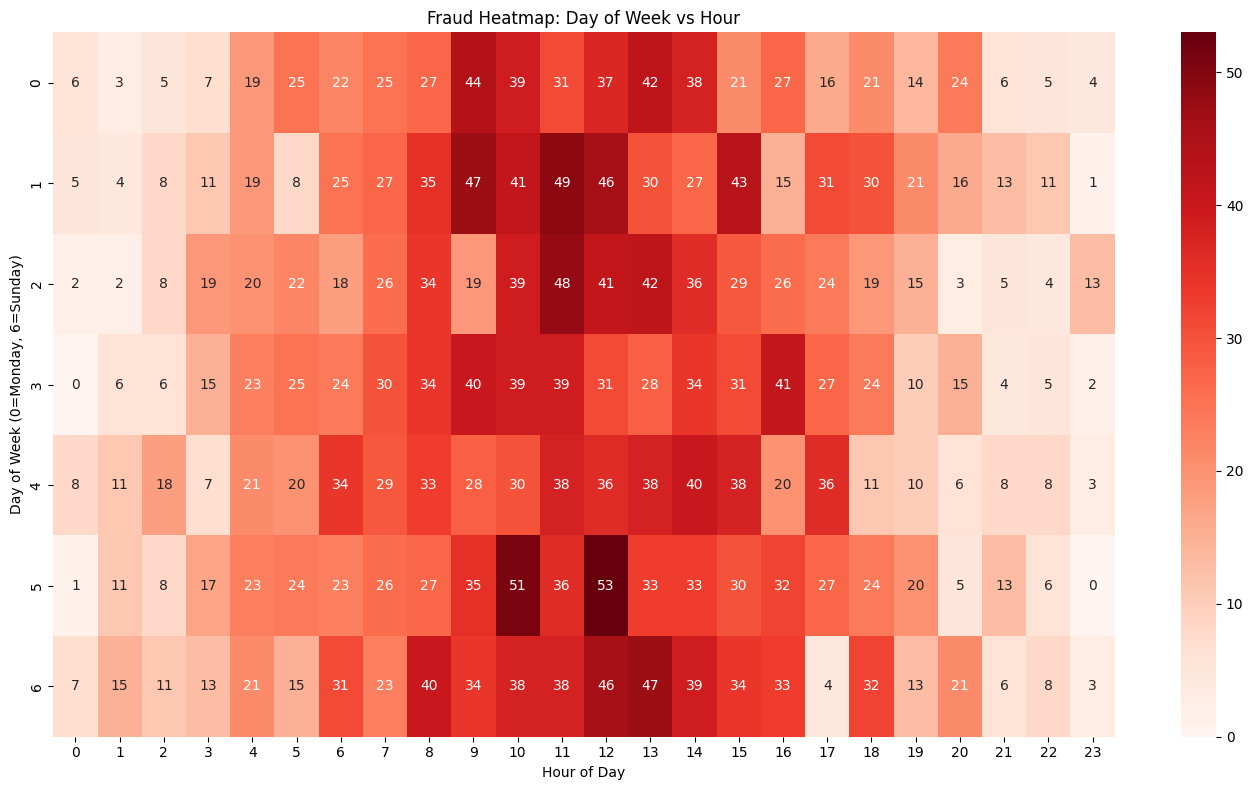

In [28]:
fraud_heatmap = trx.groupby(['day_of_week', 'hour'])['tx_fraud'].sum().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(fraud_heatmap, annot=True, fmt='d', cmap='Reds')
plt.title('Fraud Heatmap: Day of Week vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.tight_layout()
plt.show()

#### Observations

* Most of the frauds happens on Saturday, at 10:00 and 12:00

### Daily fraud over time

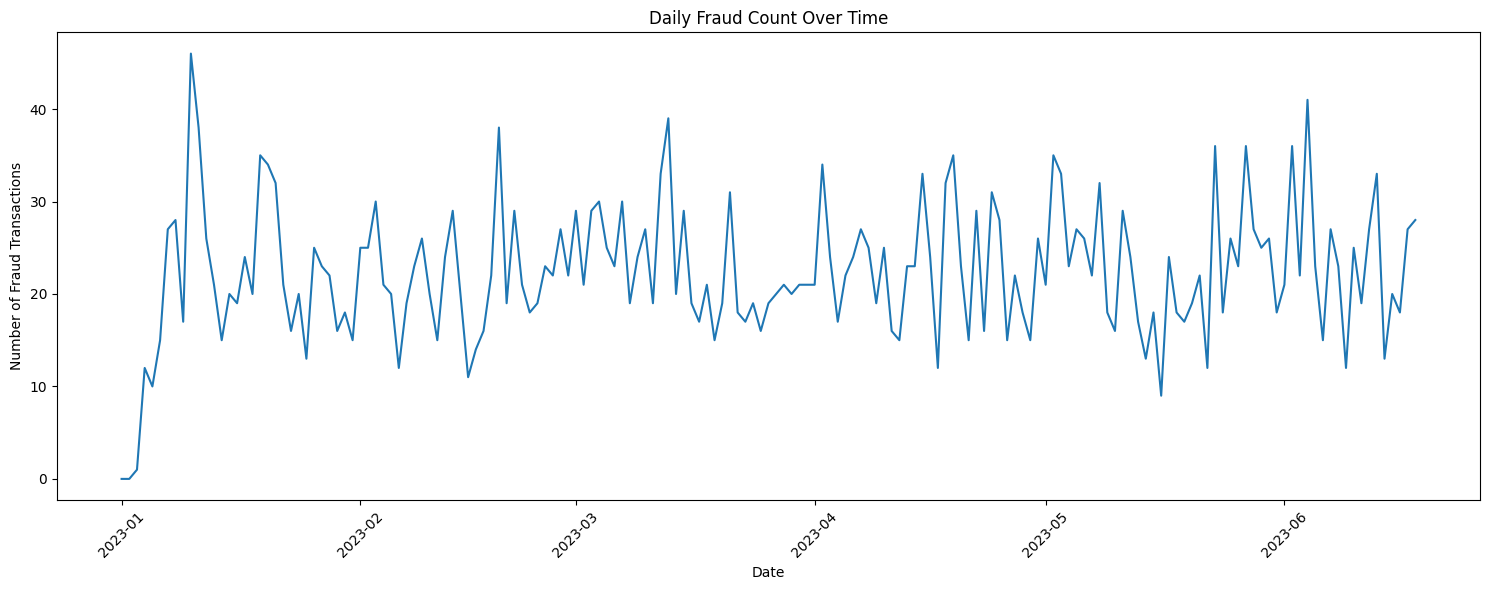

In [29]:
fraud_timeline = trx.copy()
fraud_timeline['date'] = fraud_timeline['tx_datetime'].dt.date
fraud_timeline = fraud_timeline.groupby('date')['tx_fraud'].sum().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=fraud_timeline, x='date', y='tx_fraud')
plt.title('Daily Fraud Count Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fraud and time comparisons

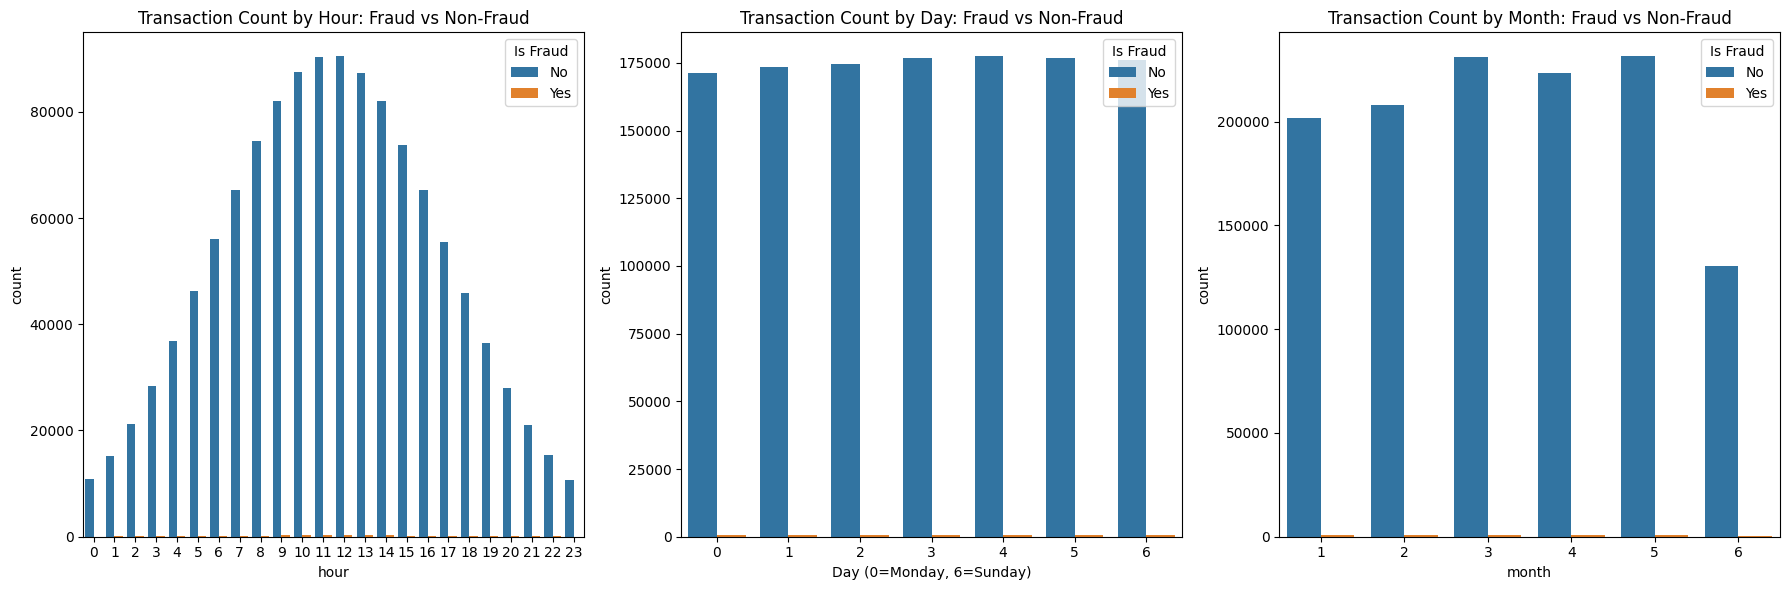

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(data=trx, x='hour', hue='tx_fraud', ax=axes[0])
axes[0].set_title('Transaction Count by Hour: Fraud vs Non-Fraud')
axes[0].legend(title='Is Fraud', labels=['No', 'Yes'])

sns.countplot(data=trx, x='day_of_week', hue='tx_fraud', ax=axes[1])
axes[1].set_title('Transaction Count by Day: Fraud vs Non-Fraud')
axes[1].set_xlabel('Day (0=Monday, 6=Sunday)')
axes[1].legend(title='Is Fraud', labels=['No', 'Yes'])

sns.countplot(data=trx, x='month', hue='tx_fraud', ax=axes[2])
axes[2].set_title('Transaction Count by Month: Fraud vs Non-Fraud')
axes[2].legend(title='Is Fraud', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

# Feature Engineering

Define variables, where feauture names are going to be stored

In [31]:
AMOUNT_FEATURES = {
    'tx_amount': set(),
    'tx_amount_log': set()
}
WINDOWS = ['7d', '14d', '21d', '30d']
SECTOR_FEATURES = set()
CUSTOMER_FEATURES = set()
DATE_FEATURES = set()
ROLLING_FEATURES = set()
RISK_FEATURES = set()
TOP_PERCENTILE_FEATURES = []

Sort dataset for the sake of simplicity (user and then transactions)

In [32]:
trx = trx.sort_values(['customer_id','tx_datetime']).reset_index(drop=True)
trx

,customer_id,tx_datetime,tx_amount,sector_id,tx_fraud,tx_amount_log,day_of_week,hour,month,is_month_start,is_month_end,is_weekend
0,0,2023-01-07 15:47:39,538.021174,4,0,6.289755,5,15,1,0,0,1
1,0,2023-01-07 18:43:44,713.726474,4,1,6.571900,5,18,1,0,0,1
2,0,2023-01-10 04:38:48,601.959471,4,0,6.401850,1,4,1,0,0,0
3,0,2023-01-10 05:55:56,608.692193,4,0,6.412954,1,5,1,0,0,0
4,0,2023-01-10 14:20:06,617.170620,4,0,6.426765,1,14,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1229916,4999,2023-06-11 11:00:58,253.544065,0,0,5.539474,6,11,6,0,0,1
1229917,4999,2023-06-12 05:04:48,309.351664,0,0,5.737706,0,5,6,0,0,0
1229918,4999,2023-06-16 13:24:22,287.262369,0,0,5.663871,4,13,6,0,0,0
1229919,4999,2023-06-17 10:09:55,286.935339,0,0,5.662736,5,10,6,0,0,1


Define `one` - technical variable, going to use it for rolling features

In [33]:
trx['ones'] = 1

## Common features

### Date-related features

In [34]:
trx['day_of_week'] = trx['tx_datetime'].dt.day_of_week
trx['hour'] = trx['tx_datetime'].dt.hour
trx['month'] = trx['tx_datetime'].dt.month
trx['is_month_start'] = trx['tx_datetime'].dt.is_month_start.astype('int')
trx['is_month_end'] = trx['tx_datetime'].dt.is_month_end.astype('int')
trx['is_weekend'] = trx['day_of_week'].isin({5, 6}).astype('int')

DATE_FEATURES = DATE_FEATURES.union([
    'day_of_week',
    'hour',
    'month',
    'is_month_start',
    'is_month_end',
    'is_weekend'
])

In [35]:
DATE_FEATURES

{'day_of_week',
 'hour',
 'is_month_end',
 'is_month_start',
 'is_weekend',
 'month'}

## Rolling features

### Split dataset

First, split initial dataset into train, validation and test scopes:

In [36]:
train_end = "2023-04-30"
val_end   = "2023-05-31"
target_column = 'tx_fraud'

X_train = trx[trx["tx_datetime"] <= train_end]
X_val   = trx[(trx["tx_datetime"] > train_end) & (trx["tx_datetime"] <= val_end)]
X_test  = trx[trx["tx_datetime"] > val_end]

y_train = X_train[target_column]
y_val = X_val[target_column]
y_test = X_test[target_column]

### Difference in time between transactions

In [37]:
for df in X_train, X_val, X_test:
    df['secs_since_prev_tx'] = (
        trx.groupby('customer_id')['tx_datetime']
        .diff()
        .dt.total_seconds()
        .fillna(-1)
    )
SECTOR_FEATURES.add('secs_since_prev_tx')

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/2013127273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secs_since_prev_tx'] = (
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/2013127273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secs_since_prev_tx'] = (
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/2013127273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [38]:
X_train = X_train.sort_values(['customer_id','tx_datetime']).reset_index(drop=True)
X_val = X_val.sort_values(['customer_id','tx_datetime']).reset_index(drop=True)
X_test = X_test.sort_values(['customer_id','tx_datetime']).reset_index(drop=True)

### Datetime intervals' aggregations for window

For each client and interval window (`7d`, `14d`, `21d`, `30d`), calculate interval mean, standard deviation, zscore and burstiness of seconds since previous transaction:

In [39]:
eps = 1e-6
for df in X_train, X_val, X_test:
       for window in WINDOWS:
              mean_col = f'interval_mean_{window}'
              std_col  = f'interval_std_{window}'
              mean_vals = (
                     df.groupby('customer_id', group_keys=False)
                            .apply(lambda d: d.set_index('tx_datetime')['secs_since_prev_tx'].shift()
                                         .rolling(window).mean())
              ).fillna(0).to_numpy()

              std_vals = (
                     df.groupby('customer_id', group_keys=False)
                            .apply(lambda d: d.set_index('tx_datetime')['secs_since_prev_tx']
                                          .shift()
                                          .rolling(window).std())
              ).fillna(0).to_numpy()

              df[f'interval_mean_{window}'] = mean_vals
              df[f'interval_std_{window}']  = std_vals
              df[f'interval_zscore_{window}'] = (
                     (df['secs_since_prev_tx'] - df[mean_col]) / (df[std_col] + eps)
              )

              df[f'interval_burstiness_{window}'] = (
                     df[std_col] / (df[mean_col] + eps)
              )
              ROLLING_FEATURES = ROLLING_FEATURES.union([
                     mean_col,
                     std_col,
                     f'interval_zscore_{window}',
                     f'interval_burstiness_{window}'
              ])

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/4136070001.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['secs_since_prev_tx'].shift()
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/4136070001.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['secs_since_prev_tx']
/var/folders/v0/8r5h4ym

In [40]:
ROLLING_FEATURES

{'interval_burstiness_14d',
 'interval_burstiness_21d',
 'interval_burstiness_30d',
 'interval_burstiness_7d',
 'interval_mean_14d',
 'interval_mean_21d',
 'interval_mean_30d',
 'interval_mean_7d',
 'interval_std_14d',
 'interval_std_21d',
 'interval_std_30d',
 'interval_std_7d',
 'interval_zscore_14d',
 'interval_zscore_21d',
 'interval_zscore_30d',
 'interval_zscore_7d'}

### Number of transactions in window

In [41]:
for df in X_train, X_val, X_test:
    for window in WINDOWS + ['1h', '1d']:
        vals = (
            df.groupby('customer_id', group_keys=False)
              .apply(lambda d: d.set_index('tx_datetime')['ones']
                                .shift() # Exclude current transaction
                                .rolling(window)
                                .count())
        ).to_numpy()
        df[f'tx_count_{window}'] = vals
        ROLLING_FEATURES.add(f'tx_count_{window}')

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/458307417.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['ones']
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/458307417.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['ones']
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_727

### Number of client's transactions in sector

In [42]:
for df in X_train, X_val, X_test:
    for window in WINDOWS + ['1h', '1d']:
        vals = (
            df.groupby(['customer_id','sector_id'])
            .apply(lambda d: d.set_index('tx_datetime')['tx_amount']
                                .shift()
                                .rolling(window, closed='both')
                                .count())
        ).to_numpy()
        df[f'tx_count_sector_{window}'] = vals
        ROLLING_FEATURES.add(f'tx_count_sector_{window}')

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/847003903.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['tx_amount']
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/847003903.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['tx_amount']
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipy

In [43]:
ROLLING_FEATURES

{'interval_burstiness_14d',
 'interval_burstiness_21d',
 'interval_burstiness_30d',
 'interval_burstiness_7d',
 'interval_mean_14d',
 'interval_mean_21d',
 'interval_mean_30d',
 'interval_mean_7d',
 'interval_std_14d',
 'interval_std_21d',
 'interval_std_30d',
 'interval_std_7d',
 'interval_zscore_14d',
 'interval_zscore_21d',
 'interval_zscore_30d',
 'interval_zscore_7d',
 'tx_count_14d',
 'tx_count_1d',
 'tx_count_1h',
 'tx_count_21d',
 'tx_count_30d',
 'tx_count_7d',
 'tx_count_sector_14d',
 'tx_count_sector_1d',
 'tx_count_sector_1h',
 'tx_count_sector_21d',
 'tx_count_sector_30d',
 'tx_count_sector_7d'}

### Transaction's amount relatively to history

In [44]:
for df in X_train, X_val, X_test:
    for amount_col in AMOUNT_FEATURES.keys():
        exp_mean = (df.groupby('customer_id', group_keys=False)[amount_col]
                    .apply(lambda s: s.shift().expanding().mean()))
        exp_std  = (df.groupby('customer_id', group_keys=False)[amount_col]
                    .apply(lambda s: s.shift().expanding().std()))

        df['customer_exp_mean'] = exp_mean.to_numpy()
        df['customer_exp_std']  = exp_std.to_numpy()

        df['ratio_to_customer_mean']  = df[amount_col] / (df['customer_exp_mean'] + eps)
        df['zscore_amount_customer']  = (df[amount_col] - df['customer_exp_mean']) / (df['customer_exp_std'] + eps)
        for window in WINDOWS:
            mean_vals = (df.groupby('customer_id', group_keys=False)
                       .apply(lambda d: d.set_index('tx_datetime')[amount_col]
                                         .rolling(window, closed='left').mean())
                    ).to_numpy()
            df[f'{amount_col}_mean_{window.lower()}'] = mean_vals

            median_vals = (df.groupby('customer_id', group_keys=False)
                            .apply(lambda d: d.set_index('tx_datetime')[amount_col]
                                            .rolling(window, closed='left').median())
                        ).to_numpy()
            df[f'{amount_col}_median_{window.lower()}'] = median_vals

            std_vals = (df.groupby('customer_id', group_keys=False)
                        .apply(lambda d: d.set_index('tx_datetime')[amount_col]
                                            .rolling(window, closed='left').std())
                    ).to_numpy()
            df[f'{amount_col}_std_{window.lower()}'] = std_vals
            AMOUNT_FEATURES[amount_col] = AMOUNT_FEATURES[amount_col].union([
                f'{amount_col}_mean_{window.lower()}',
                f'{amount_col}_median_{window.lower()}',
                f'{amount_col}_std_{window.lower()}'
            ])

        fill_cols = ['customer_exp_mean','customer_exp_std','ratio_to_customer_mean','zscore_amount_customer']
        df[fill_cols] = df[fill_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
        AMOUNT_FEATURES[amount_col] = AMOUNT_FEATURES[amount_col].union(fill_cols)



/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/1465332709.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')[amount_col]
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/1465332709.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')[amount_col]
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/i

## Sector-related features

In [45]:
for df in X_train, X_val, X_test:
    last_seen = (
        df.groupby(['customer_id','sector_id'])['tx_datetime']
          .shift()
    )
    df[f'is_new_sector_30d'] = (
        (last_seen.isna()) | 
        ((df['tx_datetime'] - last_seen) > pd.Timedelta('30d'))
    ).astype(int)
    df['sector_switch_flag'] = (
        df.groupby('customer_id')['sector_id'].diff().ne(0).astype(int)
    )
    for window in WINDOWS:
        unique_sectors_vals = (
            df.groupby('customer_id', group_keys=False)
              .apply(lambda d: d.set_index('tx_datetime')['sector_id']
                                .shift()                          # исключаем текущую транзакцию
                                .rolling(window, closed='left')
                                .apply(lambda x: x.nunique(), raw=False))
        ).fillna(0).to_numpy()
        df[f'unique_sectors_{window}'] = unique_sectors_vals

        sectors_switches = (
            df.groupby('customer_id', group_keys=False)
              .apply(lambda d: d.set_index('tx_datetime')['sector_switch_flag']
                                .shift()
                                .rolling(window, closed='left').sum())
        ).fillna(0).to_numpy()
        df[f'sector_switches_{window}'] = sectors_switches
        SECTOR_FEATURES = SECTOR_FEATURES.union([
            f'unique_sectors_{window}',
            f'sector_switches_{window}'
        ])
SECTOR_FEATURES = SECTOR_FEATURES.union(['sector_switch_flag', f'is_new_sector_30d'])

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/2567663565.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['sector_id']
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/2567663565.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.set_index('tx_datetime')['sector_switch_flag']
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt5

## Risk-related features

In [46]:
def _delayed_risk_group(g: pd.DataFrame, time_col: str, target_col: str,
                        w_days: int, delay_days: int) -> pd.Series:
    g = g.sort_values(time_col)
    s = g.set_index(time_col)[target_col].astype(int)
  
    wd_sum = s.rolling(f'{w_days + delay_days}D', closed='left').sum()
    d_sum  = s.rolling(f'{delay_days}D',       closed='left').sum()
    fraud_window = wd_sum - d_sum

    wd_cnt = s.rolling(f'{w_days + delay_days}D', closed='left').count()
    d_cnt  = s.rolling(f'{delay_days}D',       closed='left').count()
    cnt_window = wd_cnt - d_cnt

    risk = (fraud_window / cnt_window.replace(0, np.nan)).fillna(0.0)
    return pd.Series(risk.values, index=g.index)

def add_delayed_risk_features(df: pd.DataFrame,
                              windows=(7, 30),
                              delay_days=7,
                              group_cols=('sector_id',),
                              time_col='tx_datetime',
                              target_col='tx_fraud',
                              prefix='sector') -> tuple[pd.DataFrame, list[str]]:
    feats = []

    # порядок и типы
    df = df.sort_values([*group_cols, time_col]).reset_index(drop=True)
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df[target_col] = df[target_col].astype(int)

    for w in windows:
        col = f'{prefix}_risk_{w}d_delay{delay_days}d'
        vals = (
            df.groupby(list(group_cols), group_keys=False)
              .apply(lambda g: _delayed_risk_group(g, time_col, target_col, w_days=w, delay_days=delay_days))
        ).to_numpy()
        df[col] = vals
        feats.append(col)

    return df, feats

In [47]:
X_train, sector_feats_tr = add_delayed_risk_features(
    X_train, windows=(7,30), delay_days=7,
    group_cols=('sector_id',), prefix='sector'
)
X_val,   sector_feats_va = add_delayed_risk_features(
    X_val,   windows=(7,30), delay_days=7,
    group_cols=('sector_id',), prefix='sector'
)
X_test,  sector_feats_te = add_delayed_risk_features(
    X_test,  windows=(7,30), delay_days=7,
    group_cols=('sector_id',), prefix='sector'
)

X_train, custsec_feats_tr = add_delayed_risk_features(
    X_train, windows=(7,30), delay_days=7,
    group_cols=('customer_id','sector_id'), prefix='customer_sector'
)
X_val,   custsec_feats_va = add_delayed_risk_features(
    X_val,   windows=(7,30), delay_days=7,
    group_cols=('customer_id','sector_id'), prefix='customer_sector'
)
X_test,  custsec_feats_te = add_delayed_risk_features(
    X_test,  windows=(7,30), delay_days=7,
    group_cols=('customer_id','sector_id'), prefix='customer_sector'
)

RISK_FEATURES = RISK_FEATURES.union(sector_feats_tr + custsec_feats_tr)

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/533576946.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _delayed_risk_group(g, time_col, target_col, w_days=w, delay_days=delay_days))
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/533576946.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _delayed_risk_group(g, time_col, target_col, w_days

Define helper function for calculating rolling mean value by window

In [48]:
def rolling_mean_timebased(df, window, column_name, agg_name):
    s = (df.set_index('tx_datetime')[column_name]
           .rolling(window, closed='left')
           .agg(agg_name))
    return s.reset_index(drop=False).set_index(df.index).iloc[:, 1]

### Aggregations of transaction amount by given window

In [49]:

eps = 1e-6
for df in [X_train, X_val, X_test]:
    for window in WINDOWS:
        for col in AMOUNT_FEATURES.keys():
            mean_ = (
                df.groupby('customer_id')
                    .apply(lambda d: rolling_mean_timebased(d, window, col, 'mean')).fillna(0)
                    .to_numpy()
            )
            std_ = (
                df.groupby('customer_id')
                    .apply(lambda d: rolling_mean_timebased(d, window, col, 'std')).fillna(0)
                    .to_numpy()
            )
            median_ = (
                df.groupby('customer_id')
                    .apply(lambda d: rolling_mean_timebased(d, window, col, 'median')).fillna(0)
                    .to_numpy()
            )
            sum_ = (
                df.groupby('customer_id')
                    .apply(lambda d: rolling_mean_timebased(d, window, col, 'sum')).fillna(0)
                    .to_numpy()
            )
            count_ = (
                df.groupby('customer_id')
                    .apply(lambda d: rolling_mean_timebased(d, window, col, 'count')).fillna(0)
                    .to_numpy()
            )
            df[f'{col}_mean_{window}'] = mean_
            df[f'{col}_std_{window}'] = std_
            df[f'{col}_median_{window}'] = median_
            df[f'{col}_sum_{window}'] = sum_
            df[f'{col}_count_{window}'] = count_

            df[f'{col}_zscore_{window}'] = (df[col] - mean_) / (std_ + eps)
            df[f'{col}_ration_to_mean_{window}'] = df[col] / (mean_ + eps)

            AMOUNT_FEATURES[col] = AMOUNT_FEATURES[col].union([
                f'{col}_mean_{window}',
                f'{col}_std_{window}',
                f'{col}_median_{window}',
                f'{col}_sum_{window}',
                f'{col}_count_{window}',
                f'{col}_zscore_{window}',
                f'{col}_ration_to_mean_{window}'
            ])

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/3279698374.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: rolling_mean_timebased(d, window, col, 'mean')).fillna(0)
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/3279698374.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: rolling_mean_timebased(d, window, col, 'std')).fillna(0)
/var/folders/v

#### 

### Delay of fraud transaction for sector

In [50]:
def delayed_sector_stats_group(g: pd.DataFrame, time_col: str, target_col: str,
                               delay_days: int, w_days: int) -> pd.DataFrame:
    g = g.sort_values(time_col)
    y = g[target_col].astype(int)
    s = pd.Series(y.values, index=pd.to_datetime(g[time_col].values))

    wd = s.rolling(f'{w_days + delay_days}D', closed='left')
    d  = s.rolling(f'{delay_days}D',          closed='left')

    fraud_window = wd.sum() - d.sum()
    cnt_window   = wd.count() - d.count()

    risk = (fraud_window / cnt_window.replace(0, np.nan)).fillna(0.0)
    count = cnt_window.fillna(0.0)

    return pd.DataFrame({
        f'risk_{w_days}d_delay{delay_days}d': risk.to_numpy(),
        f'tx_{w_days}d_delay{delay_days}d': count.to_numpy()
    }, index=g.index)

In [51]:
delay_period = 7
for df in [X_train, X_val, X_test]:
    for w in [7, 14, 21, 30]:
        df_stats = (df.groupby('sector_id', group_keys=False)
                    .apply(lambda g: delayed_sector_stats_group(
                        g, time_col='tx_datetime', target_col='tx_fraud',
                        delay_days=delay_period, w_days=w)))
        for col in df_stats.columns:
            df[f'sector_{col}'] = df_stats[col].to_numpy()
            SECTOR_FEATURES.add(f'sector_{col}')

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/3142848317.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: delayed_sector_stats_group(
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/3142848317.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: delayed_sector_stats_group(
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/314284831

### Average and std transaction amount for customer within window

In [52]:
for df in [X_train, X_val, X_test]:
    for col in  AMOUNT_FEATURES.keys():
        for window in WINDOWS:
                tx_window_col = f'customer_id_{col}_mean_{window}_window'
                tx_avg_amount_col = f'customer_id_{col}_std_{window}_window'

                mean_ = df.set_index('tx_datetime').groupby('customer_id')[col].apply(lambda s: s.shift().rolling(window).mean())
                std_ = df.set_index('tx_datetime').groupby('customer_id')[col].apply(lambda s: s.shift().rolling(window).std())
                df[tx_window_col] = mean_.to_numpy()
                df[tx_avg_amount_col] = std_.to_numpy()
                df[tx_window_col] = df[tx_window_col].fillna(0)
                df[tx_avg_amount_col] = df[tx_avg_amount_col].fillna(0)
                AMOUNT_FEATURES[col] = AMOUNT_FEATURES[col].union([
                    tx_window_col,
                    tx_avg_amount_col
                ])

### Top percentile of transaction for customer

In [53]:
def add_customer_top_percentile_flags(
    df: pd.DataFrame,
    amount_col: str = "tx_amount_log",
    percentiles = (95, 99),
    windows = (None, "30D", "7D")
) -> pd.DataFrame:
    df = df.sort_values(['customer_id','tx_datetime']).reset_index(drop=True)
    df['tx_datetime'] = pd.to_datetime(df['tx_datetime'], errors='coerce')

    if None in windows:
        for p in percentiles:
            thr = (df.groupby('customer_id', group_keys=False)[amount_col]
                     .apply(lambda s: s.shift().expanding().quantile(p/100.0)))
            col_thr = f'{amount_col}_thr_hist_p{p}'
            df[col_thr] = thr.fillna(0).to_numpy()
            df[f'top_p_hist_{p}'] = (df[amount_col] >= df[col_thr]).astype('int8')

    for w in windows:
        if w is None:
            continue
        for p in percentiles:
            thr = (df.groupby('customer_id', group_keys=False)
                     .apply(lambda g: g.set_index('tx_datetime')[amount_col]
                                        .rolling(w, closed='left')
                                        .quantile(p/100.0))
                  ).fillna(0).to_numpy()
            col_thr = f'{amount_col}_thr_{w}_p{p}'
            df[col_thr] = thr
            df[f'top_p_{w}_p{p}'] = (df[amount_col] >= df[col_thr]).astype('int8')

    flag_cols = [c for c in df.columns if c.startswith('top_p_')]
    df[flag_cols] = df[flag_cols].fillna(0)

    return df

In [54]:
X_train = add_customer_top_percentile_flags(X_train, amount_col='tx_amount_log', percentiles=(95,99), windows=WINDOWS + [None])
X_val   = add_customer_top_percentile_flags(X_val,   amount_col='tx_amount_log', percentiles=(95,99), windows=WINDOWS + [None])
X_test  = add_customer_top_percentile_flags(X_test,  amount_col='tx_amount_log', percentiles=(95,99), windows=WINDOWS + [None])

TOP_PERCENTILE_FEATURES += [c for c in X_train.columns if c.startswith('top_p_')]

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/2892768174.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('tx_datetime')[amount_col]
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_72716/2892768174.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('tx_datetime')[amount_col]
/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/i

In [55]:
trx = trx.sort_values(['tx_datetime']).reset_index(drop=True)

### Calculate `tx_amount` features for customer and globally

In [56]:
for df in [X_train, X_val, X_test]:
    for col in AMOUNT_FEATURES.keys():
        df[f'{col}_mean_customer'] = df.groupby('customer_id')[col].transform('mean').fillna(0)
        df[f'{col}_std_customer'] = df.groupby('customer_id')[col].transform('std').fillna(0)
        df[f'{col}_median_customer'] = df.groupby('customer_id')[col].transform('median').fillna(0)

        df[f'{col}_zscore_customer'] = (df[col] - df[f'{col}_mean_customer']) / (df[f'{col}_std_customer'] + eps)
        df[f'{col}_ration_to_mean_customer'] = df[col] / (df[f'{col}_mean_customer'] + eps)

        df[f'{col}_mean_global'] = df[col].mean()
        df[f'{col}_std_global'] = df[col].std()
        df[f'{col}_median_global'] = df[col].median()

        df[f'{col}_zscore_global'] = (df[col] - df[f'{col}_mean_global']) / (df[f'{col}_std_global'] + eps)
        df[f'{col}_ration_to_mean_global'] = df[col] / (df[f'{col}_mean_global'] + eps)

        AMOUNT_FEATURES[col] = AMOUNT_FEATURES[col].union([
            f'{col}_mean_customer',
            f'{col}_std_customer',
            f'{col}_median_customer',
            f'{col}_zscore_customer',
            f'{col}_ration_to_mean_customer',
            f'{col}_mean_global',
            f'{col}_std_global',
            f'{col}_median_global',
            f'{col}_zscore_global',
            f'{col}_ration_to_mean_global'
        ])

#### Datetime difference-based features

In [57]:
for df in [X_train, X_val, X_test]:
    df['tx_datetime_diff_customer'] = df.groupby('customer_id')['tx_datetime'].diff().dt.total_seconds()
    df['tx_datetime_diff_customer'] = df['tx_datetime_diff_customer'].fillna(0)
    df['tx_datetime_diff_mean_customer'] = df.groupby('customer_id')['tx_datetime_diff_customer'].transform('mean')
    df['tx_datetime_diff_mean_customer'] = df['tx_datetime_diff_mean_customer'].fillna(0)
    df['tx_datetime_diff_median_customer'] = df.groupby('customer_id')['tx_datetime_diff_customer'].transform('median')
    df['tx_datetime_diff_median_customer'] = df['tx_datetime_diff_median_customer'].fillna(0)
    df['tx_datetime_diff_std_customer'] = df.groupby('customer_id')['tx_datetime_diff_customer'].transform('std')
    df['tx_datetime_diff_std_customer'] = df['tx_datetime_diff_std_customer'].fillna(0)

    df['tx_datetime_diff_global'] = df['tx_datetime'].diff().dt.total_seconds()
    df['tx_datetime_diff_global'] = df['tx_datetime_diff_global'].fillna(0)
    df['tx_datetime_diff_mean_global'] = df['tx_datetime_diff_global'].mean()
    df['tx_datetime_diff_mean_global'] = df['tx_datetime_diff_mean_global'].fillna(0)
    df['tx_datetime_diff_median_global'] = df['tx_datetime_diff_global'].median()
    df['tx_datetime_diff_median_global'] = df['tx_datetime_diff_median_global'].fillna(0)
    df['tx_datetime_diff_std_global'] = df['tx_datetime_diff_global'].std()
    df['tx_datetime_diff_std_global'] = df['tx_datetime_diff_std_global'].fillna(0)

DATE_FEATURES = DATE_FEATURES.union([
    'tx_datetime_diff_customer',
    'tx_datetime_diff_mean_customer',
    'tx_datetime_diff_median_customer',
    'tx_datetime_diff_std_customer',
    'tx_datetime_diff_global',
    'tx_datetime_diff_mean_global',
    'tx_datetime_diff_median_global',
    'tx_datetime_diff_std_global'
])

## Final features list

Prepare final features list and dataframes for model training

In [58]:
AMOUNT_FEATURES['tx_amount_log']

{'customer_exp_mean',
 'customer_exp_std',
 'customer_id_tx_amount_log_mean_14d_window',
 'customer_id_tx_amount_log_mean_21d_window',
 'customer_id_tx_amount_log_mean_30d_window',
 'customer_id_tx_amount_log_mean_7d_window',
 'customer_id_tx_amount_log_std_14d_window',
 'customer_id_tx_amount_log_std_21d_window',
 'customer_id_tx_amount_log_std_30d_window',
 'customer_id_tx_amount_log_std_7d_window',
 'ratio_to_customer_mean',
 'tx_amount_log_count_14d',
 'tx_amount_log_count_21d',
 'tx_amount_log_count_30d',
 'tx_amount_log_count_7d',
 'tx_amount_log_mean_14d',
 'tx_amount_log_mean_21d',
 'tx_amount_log_mean_30d',
 'tx_amount_log_mean_7d',
 'tx_amount_log_mean_customer',
 'tx_amount_log_mean_global',
 'tx_amount_log_median_14d',
 'tx_amount_log_median_21d',
 'tx_amount_log_median_30d',
 'tx_amount_log_median_7d',
 'tx_amount_log_median_customer',
 'tx_amount_log_median_global',
 'tx_amount_log_ration_to_mean_14d',
 'tx_amount_log_ration_to_mean_21d',
 'tx_amount_log_ration_to_mean_30

In [59]:
SECTOR_FEATURES

{'is_new_sector_30d',
 'secs_since_prev_tx',
 'sector_risk_14d_delay7d',
 'sector_risk_21d_delay7d',
 'sector_risk_30d_delay7d',
 'sector_risk_7d_delay7d',
 'sector_switch_flag',
 'sector_switches_14d',
 'sector_switches_21d',
 'sector_switches_30d',
 'sector_switches_7d',
 'sector_tx_14d_delay7d',
 'sector_tx_21d_delay7d',
 'sector_tx_30d_delay7d',
 'sector_tx_7d_delay7d',
 'unique_sectors_14d',
 'unique_sectors_21d',
 'unique_sectors_30d',
 'unique_sectors_7d'}

In [60]:
DATE_FEATURES

{'day_of_week',
 'hour',
 'is_month_end',
 'is_month_start',
 'is_weekend',
 'month',
 'tx_datetime_diff_customer',
 'tx_datetime_diff_global',
 'tx_datetime_diff_mean_customer',
 'tx_datetime_diff_mean_global',
 'tx_datetime_diff_median_customer',
 'tx_datetime_diff_median_global',
 'tx_datetime_diff_std_customer',
 'tx_datetime_diff_std_global'}

In [61]:
RISK_FEATURES

{'customer_sector_risk_30d_delay7d',
 'customer_sector_risk_7d_delay7d',
 'sector_risk_30d_delay7d',
 'sector_risk_7d_delay7d'}

In [62]:
ROLLING_FEATURES

{'interval_burstiness_14d',
 'interval_burstiness_21d',
 'interval_burstiness_30d',
 'interval_burstiness_7d',
 'interval_mean_14d',
 'interval_mean_21d',
 'interval_mean_30d',
 'interval_mean_7d',
 'interval_std_14d',
 'interval_std_21d',
 'interval_std_30d',
 'interval_std_7d',
 'interval_zscore_14d',
 'interval_zscore_21d',
 'interval_zscore_30d',
 'interval_zscore_7d',
 'tx_count_14d',
 'tx_count_1d',
 'tx_count_1h',
 'tx_count_21d',
 'tx_count_30d',
 'tx_count_7d',
 'tx_count_sector_14d',
 'tx_count_sector_1d',
 'tx_count_sector_1h',
 'tx_count_sector_21d',
 'tx_count_sector_30d',
 'tx_count_sector_7d'}

In [63]:
TOP_PERCENTILE_FEATURES

['top_p_hist_95',
 'top_p_hist_99',
 'top_p_7d_p95',
 'top_p_7d_p99',
 'top_p_14d_p95',
 'top_p_14d_p99',
 'top_p_21d_p95',
 'top_p_21d_p99',
 'top_p_30d_p95',
 'top_p_30d_p99']

In [64]:
FEATURES = list(
    AMOUNT_FEATURES['tx_amount_log'] | 
    SECTOR_FEATURES | 
    DATE_FEATURES | 
    RISK_FEATURES | 
    ROLLING_FEATURES | 
    set(TOP_PERCENTILE_FEATURES)
)
FEATURES

['sector_risk_30d_delay7d',
 'zscore_amount_customer',
 'interval_mean_14d',
 'sector_tx_21d_delay7d',
 'interval_std_21d',
 'sector_switch_flag',
 'sector_risk_7d_delay7d',
 'tx_count_14d',
 'tx_amount_log_zscore_30d',
 'tx_amount_log_ration_to_mean_global',
 'top_p_hist_95',
 'interval_mean_30d',
 'tx_datetime_diff_std_global',
 'tx_amount_log_ration_to_mean_7d',
 'tx_amount_log_count_21d',
 'tx_amount_log_mean_21d',
 'secs_since_prev_tx',
 'customer_id_tx_amount_log_std_21d_window',
 'tx_amount_log_std_global',
 'tx_amount_log_std_30d',
 'interval_zscore_7d',
 'customer_exp_mean',
 'tx_amount_log_std_7d',
 'tx_amount_log_sum_21d',
 'tx_amount_log_zscore_7d',
 'sector_risk_21d_delay7d',
 'tx_amount_log_ration_to_mean_21d',
 'tx_amount_log_sum_30d',
 'sector_risk_14d_delay7d',
 'hour',
 'tx_datetime_diff_median_global',
 'tx_count_sector_21d',
 'tx_amount_log_median_7d',
 'customer_sector_risk_30d_delay7d',
 'interval_burstiness_21d',
 'top_p_30d_p99',
 'interval_std_14d',
 'tx_amount

Check if there is no `NaN` values in columns

In [65]:
null_columns = X_train.columns[X_train.isna().any()].to_list()
null_columns

[]

In [66]:
len(X_val[FEATURES].columns) == len(X_train[FEATURES].columns) == len(X_test[FEATURES].columns)

True

# Modeling

Model run under 100ms

## Sampling

In [67]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train[FEATURES], y_train)

In [68]:
print(f'Before resampling: {sum(y_train==1)} frauds')
print(f'After resampling: {sum(y_train_res==1)} frauds')

Before resampling: 2613 frauds
After resampling: 856665 frauds


## Logistic regression

In [69]:
logit = LogisticRegression(
    C=0.5,
    n_jobs=4,
    solver='lbfgs', 
    random_state=42, 
    verbose=1, 
    class_weight='balanced',
    tol=0.0001,
    max_iter=500
)

In [70]:
logit.fit(X_train_res[FEATURES], y_train_res)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/vadim.sokoltsov/learning/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [71]:
y_pred_proba = logit.predict_proba(X_val[FEATURES])
y_predict = logit.predict(X_val[FEATURES])

### Validation

In [72]:
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])
pr_auc = average_precision_score(y_val, y_pred_proba[:, 1])

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")

ROC AUC: 0.505
PR AUC: 0.003


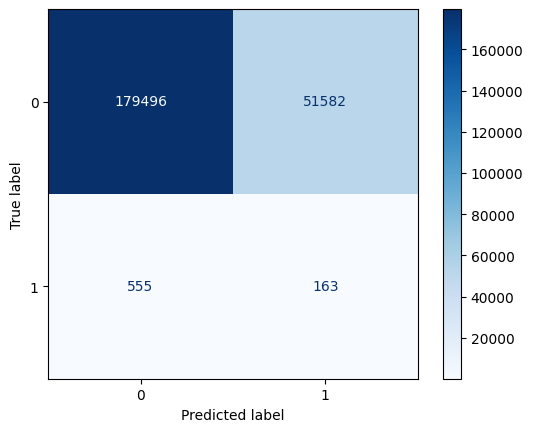

In [73]:
cm = confusion_matrix(y_val, y_predict, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

In [74]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba[:, 1])
f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
best_thr = thresholds[f1_scores.argmax()]
print("Best threshold:", best_thr)

Best threshold: 0.9938374876065678


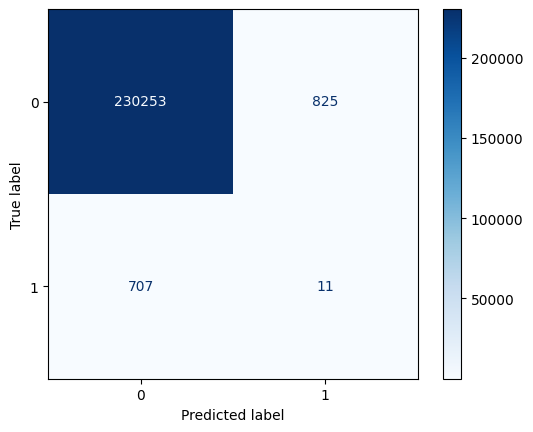

In [75]:
# Recalculate preductions with this threshold
y_pred_opt = (y_pred_proba[:, 1] >= best_thr).astype(int)
cm = confusion_matrix(y_val, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

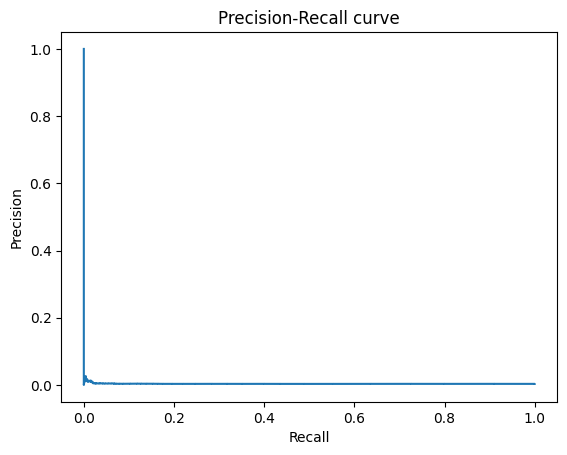

In [76]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

## Decision tree

In [77]:
dtree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_split=30,
    min_samples_leaf=5,
    class_weight='balanced',
    max_features='log2',
    random_state=42,
    min_weight_fraction_leaf=0.1
)

In [78]:
dtree.fit(X_train_res[FEATURES], y_train_res)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,30
,min_samples_leaf,5
,min_weight_fraction_leaf,0.1
,max_features,'log2'
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [79]:
y_dtree_proba = dtree.predict_proba(X_val[FEATURES])

### Validation

In [80]:
precision, recall, thresholds = precision_recall_curve(y_val, y_dtree_proba[:, 1])

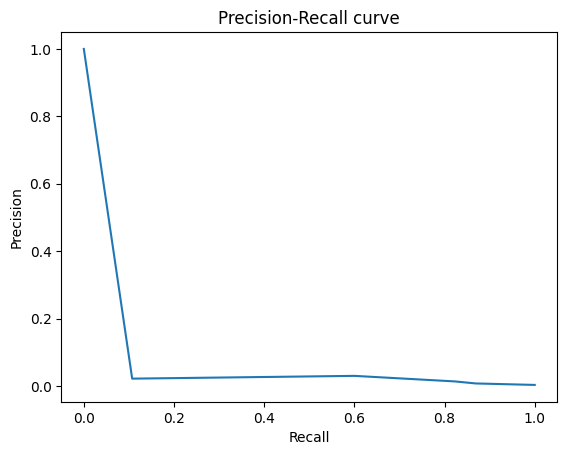

In [81]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [82]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='log2',
    class_weight="balanced",
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

In [83]:
rf.fit(X_train_res[FEATURES], y_train_res)

,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [84]:
y_rf_pred_proba = rf.predict_proba(X_val[FEATURES])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_rf_pred_proba)

In [85]:
roc_auc = roc_auc_score(y_val, y_rf_pred_proba)
pr_auc = average_precision_score(y_val, y_rf_pred_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")

ROC AUC: 0.953
PR AUC: 0.476


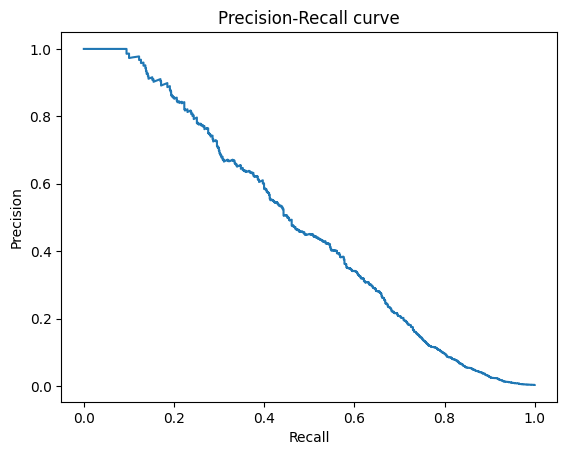

In [86]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

Best threshold: 0.6608163580234394


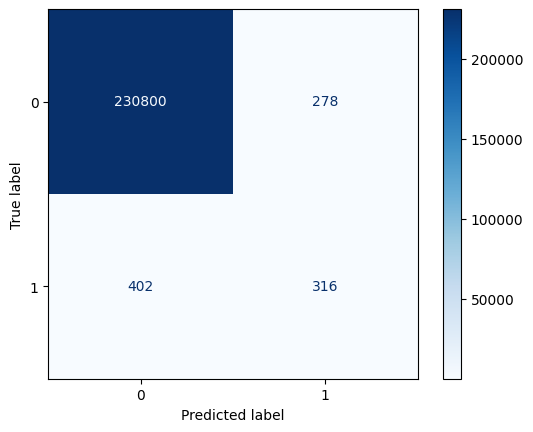

In [87]:
f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
best_thr = thresholds[f1_scores.argmax()]
print("Best threshold:", best_thr)
y_pred_opt = (y_rf_pred_proba >= best_thr).astype(int)
cm = confusion_matrix(y_val, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

## XGBoost

In [90]:
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos

# params = {
#     "objective": "binary:logistic",
#     "eval_metric": "aucpr",
#     "scale_pos_weight": scale_pos_weight,
#     "max_depth": 4,
#     "min_child_weight": 10,
#     "gamma": 1.0,
#     "eta": 0.1,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "random_state": 42
# }
# dtrain = xgb.DMatrix(X_train.drop(columns=['tx_fraud', 'tx_datetime']), label=y_train)
# dval   = xgb.DMatrix(X_val.drop(columns=['tx_fraud', 'tx_datetime']), label=y_val)

# model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=2000,
#     evals=[(dtrain, "train"), (dval, "val")],
#     early_stopping_rounds=100,
#     verbose_eval=100
# )
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    max_depth=4,
    min_child_weight=10,
    gamma=1.0,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_estimators=2000,
    early_stopping_rounds=100
)

In [ ]:
model.fit(
    X_train.drop(columns=['tx_fraud', 'tx_datetime']), 
    y_train,
    eval_set=[(X_val.drop(columns=['tx_fraud', 'tx_datetime']), y_val)],
    verbose=100
)
# Try CatBoost

[0]	validation_0-aucpr:0.11988
[100]	validation_0-aucpr:0.60974
[200]	validation_0-aucpr:0.60226
[206]	validation_0-aucpr:0.60211


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'aucpr'


In [95]:
# y_xb_pred = model.predict(dval)
y_xb_pred = model.predict(X_val.drop(columns=['tx_fraud', 'tx_datetime']))
y_xb_pred_proba = model.predict_proba(X_val.drop(columns=['tx_fraud', 'tx_datetime']))[:, 1]

### Validation

In [102]:
precision, recall, thresholds = precision_recall_curve(y_val, y_xb_pred_proba)
roc_auc = roc_auc_score(y_val, y_xb_pred_proba)
pr_auc = average_precision_score(y_val, y_xb_pred_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")

ROC AUC: 0.966
PR AUC: 0.611


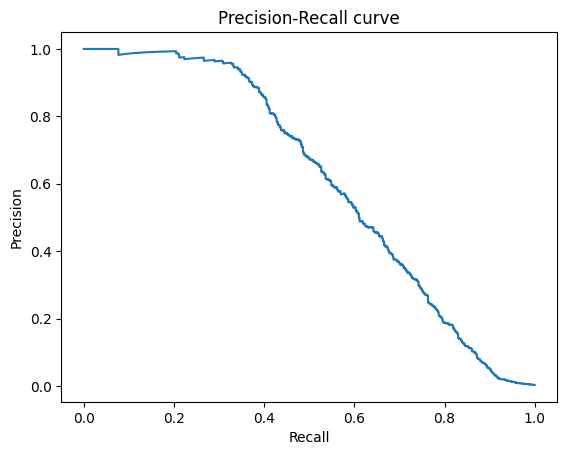

In [ ]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

# Display "good" threshold on the plot
# Explain
# Models drifting
# Do not train model for specific for user
# What is dvc format?

Best threshold: 0.97934365


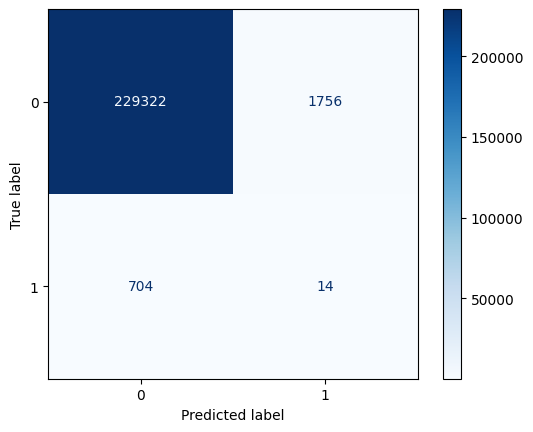

In [ ]:
f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
# 1. f_2 threshold
# 2. Balance precision / recall
best_thr = thresholds[f1_scores.argmax()]
print("Best threshold:", best_thr)

y_pred_opt = (y_pred_proba[:, 1] >= best_thr).astype(int)
cm = confusion_matrix(y_val, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

## Feature importance

### For XGBoost

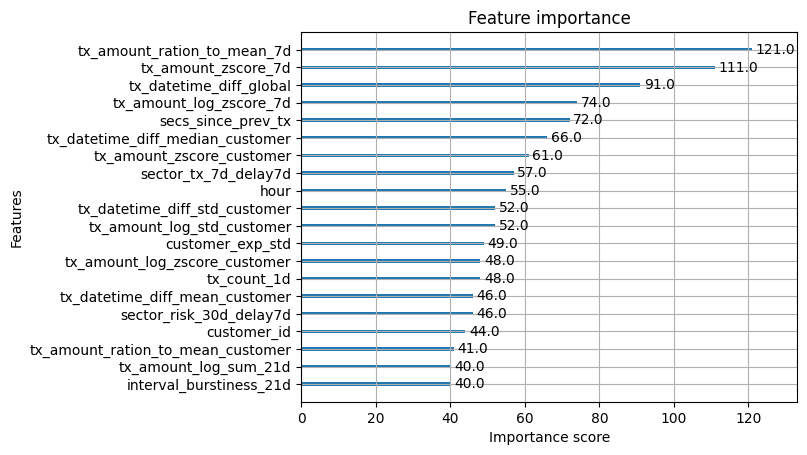

In [105]:
xgb.plot_importance(model, max_num_features=20)
plt.show()

### In general

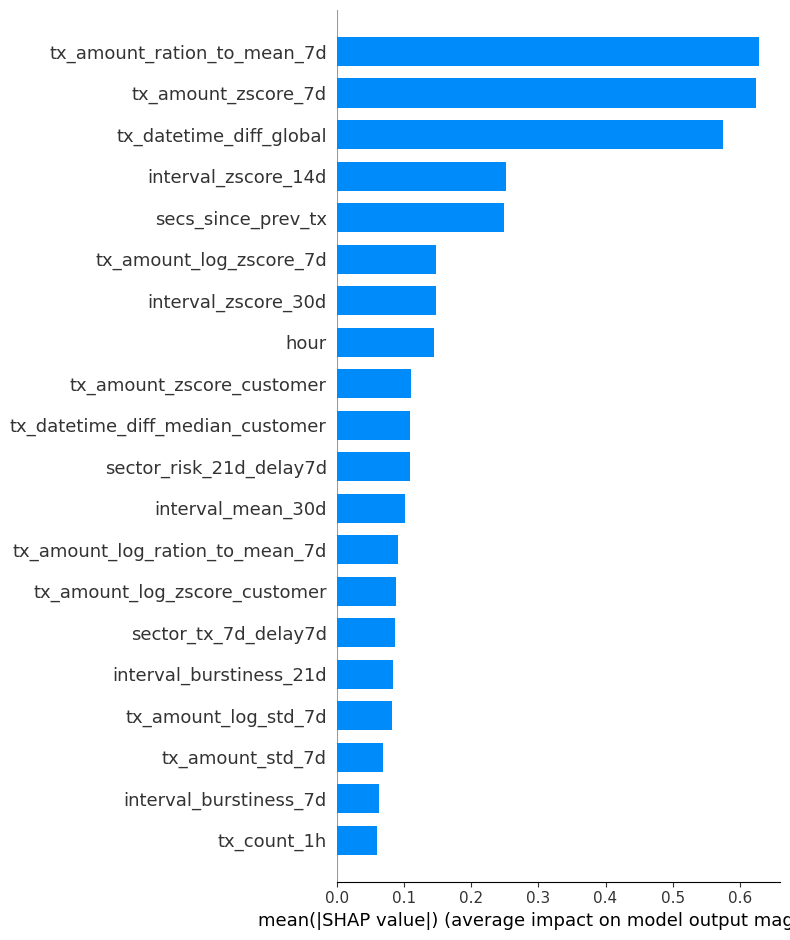

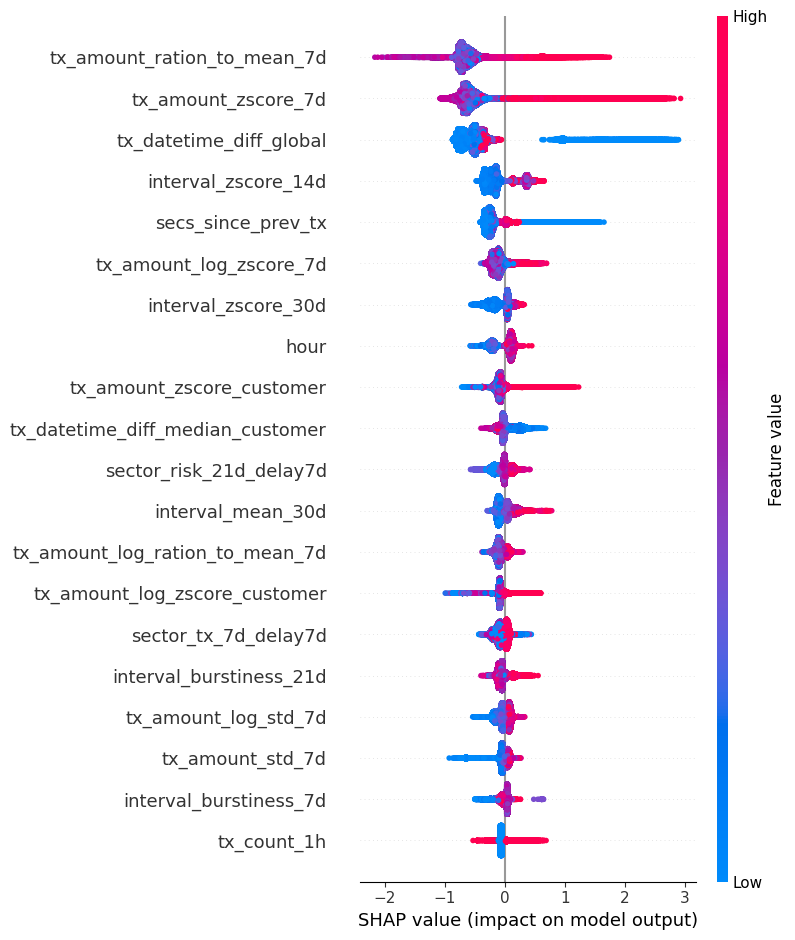

In [106]:
import shap

X_explain = X_val.drop(columns=['tx_fraud', 'tx_datetime'])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_explain)

# 4. Summary plot
shap.summary_plot(shap_values, X_explain, plot_type="bar")
shap.summary_plot(shap_values, X_explain)

## Tune model

TBD

## Save model

TBD